In [311]:
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots
using ECOS, Convex
using Mosek, MosekTools

In [312]:
#Currently working with a small tracking cost. Will implement the cost to go constraint now. 

In [313]:
#Fixes to try: 
#1. Get discrete dynamics jacobians with RK4. Matrix exponential is only exact for LTI systems. (done)
#2. Implement the second order correction (done) (not needed, it was a bug with the reference trajectory)
#3. More conservative half space constraint (done)
#4. Change the c at each knot point according to the maximum delta x deviation possible

#4. Current orbit is not exactly periodic (xend - xinitial). Set the reference trajectory to that orbit revd twice instead of concatenating two arrays (potential fix)

In [314]:
#Current bug: reference_trajectory2 has to be updated in the half solve. Currently it is the wrong dynamics constraint since the reference trajectory is
# from the beginning.  

In [315]:
# #scaled dynamics in the user defined custom units  
# function threebp_dynamics_scaled(x, u)
    
#     q_original = zeros(eltype(x),3)
#     v_original = zeros(eltype(x),3)
#     q_original = x[1:3]*custom_position_scale 
#     v_original = x[4:6]*custom_velocity_scale
    
#     x_original = [q_original; v_original]
    
#     if Lagrange_Point == "L1"
        
#         #L1 Lagrange Point for Earth Moon System (from the lagrange file)
#         L = [0.8369180073169304, 0,0,0,0,0]

#     else
        
#         #L2 Lagrange Point for Earth Moon System (from the lagrange file)
#         L = [1.1556799130947355,0,0,0,0,0]

#     end
    
#     #get it back to original units and without the L1 shift  
#     x_original_unshift = x_original+L
    
#     ẋ_original = zeros(eltype(x),6)
    
#     #calculate the original xdot (no scaling)
#     ẋ_original = threebp_dynamics(x_original_unshift, u)

#     #then scale these dynamics
#     v_scaled = ẋ_original[1:3]/custom_velocity_scale
    
#     a_scaled = ẋ_original[4:6]/custom_accel_scale
        
#     ẋ_scaled = [v_scaled; a_scaled]

#     return ẋ_scaled
# end

In [316]:
#from the Lyaponov orbit
#x0_lyapunov = [ 1.1556814491008298,
# -1.4319993886822296e-21,
#  0.0,
#  2.2212106056655213e-21,
# -8.333136405918907e-6,
#  0.0]



 #lyapunov_period = 3.3732524857835884


In [317]:
# T_og = 2.361e6 #in seconds - orbital period of m1 and m2
# time_scale_og = T_og/(2*pi)

In [318]:
#og_time_scale = 2.361e6/(2*pi)

375764.8206399649

In [678]:
#parameters for Earth Moon System
μ = 1.901109735892602e-7
μ1 = 1-μ
μ2 = μ

#position of mass 1
pose_m1 = [-μ, 0, 0]

#position of mass 2
pose_m2 = [1-μ, 0, 0]

#value obtained from 3BP textbook (original)
L = 238529 #in km - distance between centers of m1 and m2
#V_ = 1.025 #in km/s - orbital velocity of m1
#T_ = 2.361e6 #in seconds - orbital period of m1 and m2


#working
#########################################################################################
#updated for time unit to be in days
T_ = 18913/86400 #in days - orbital period of m1 and m2
time_scale = T_/(2*pi)

#time unit of days
V_ = L/time_scale
acceleration_scale = L/((time_scale)^2)
##########################################################################################

#state of the L1 and L2 Lagrange points (computed offline)
XL1 = [0.99601828, 0, 0, 0, 0, 0]
XL2 = [1.00399194, 0, 0, 0, 0, 0]

6-element Vector{Float64}:
 1.00399194
 0.0
 0.0
 0.0
 0.0
 0.0

In [320]:
function effective_potential(X)
    x = X[1]
    y = X[2]
    z = X[3]

    r1 = sqrt((x+μ2)^2 + y^2 + z^2) 
    r2 = sqrt((x-μ1)^2 + y^2 + z^2)
    #assuming m3 is unit mass
   
    U = (-μ1/r1)-(μ2/r2)-0.5*(x^2+y^2)
   
    return U
    
end

effective_potential (generic function with 1 method)

In [321]:
function three_body_prob_dynamics(x)
    
    q = zeros(eltype(x),3)
    v = zeros(eltype(x),3)
    q = x[1:3]
    v = x[4:6]

    ẋ = zeros(eltype(x),6)
    U_q = zeros(eltype(x),3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    ẋ[1:3] = v
    ẋ[4] = 2*v[2] - U_q[1] 
    ẋ[5] = -2*v[1] - U_q[2]
    ẋ[6] = -U_q[3]

    return ẋ
end

three_body_prob_dynamics (generic function with 1 method)

In [322]:
#x[1:6] -> state
#x[7:9] -> control inputs

#coming in with SI units
function three_body_prob_dynamics_wcontrol(x)
    
    q = zeros(eltype(x),3)
    v = zeros(eltype(x),3)
    q = x[1:3]
    v = x[4:6]
    u = x[7:9]

    ẋ = zeros(eltype(x),9)
    
    U_q = zeros(eltype(x),3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    ẋ[1:3] = v
    ẋ[4] = 2*v[2] - U_q[1] + u[1] 
    ẋ[5] = -2*v[1] - U_q[2] + u[2]
    ẋ[6] = -U_q[3] + u[3]
    
    #zero order hold on the controls 
    ẋ[7:9] = zeros(3)

    return ẋ
end

three_body_prob_dynamics_wcontrol (generic function with 1 method)

In [323]:
#this just scales the dynamics by L and V_

In [324]:
#inputs are in the custom SI unit scale

function three_body_prob_dynamics_scaled(x)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)
    
    q_original = x[1:3]/L 
    v_original = x[4:6]/V_
    
    x_original = [q_original; v_original]

    #original is in the CR3BP units
    ẋ_original = zeros(eltype(x),6)

    #calculate the original xdot (no scaling)

    ẋ_original = three_body_prob_dynamics(x_original)

    #then scale the output
    v_scaled = ẋ_original[1:3]*V_
    
    a_scaled = ẋ_original[4:6]*acceleration_scale

    ẋ_scaled = [v_scaled; a_scaled]

    return ẋ_scaled

end

three_body_prob_dynamics_scaled (generic function with 1 method)

In [325]:
#inputs are in the custom scaled units

function three_body_prob_dynamics_wcontrol_scaled(x)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)
    u_original = zeros(eltype(x),3)
    
    q_original = x[1:3]/L 
    v_original = x[4:6]/V_
    u_original = x[7:9]/acceleration_scale
    
    x_original = [q_original; v_original; u_original]

    ẋ_original = zeros(eltype(x),9)

    #calculate the original xdot (no scaling)

    #xoriginal is in the CR3BP units
    ẋ_original = three_body_prob_dynamics_wcontrol(x_original)

    #then scale the output
    v_scaled = ẋ_original[1:3]*V_
    
    a_scaled = ẋ_original[4:6]*acceleration_scale

    u_scaled = ẋ_original[7:9]*acceleration_scale

    ẋ_scaled = [v_scaled; a_scaled; u_scaled]

    return ẋ_scaled

end

three_body_prob_dynamics_wcontrol_scaled (generic function with 1 method)

In [326]:
#solve using DifferentialEquations.jl
function ST_and_dynamics_DFJL_wcontrol!(du, u, p, t)
    
    #original CR3BP units
    #du[1:9] = three_body_prob_dynamics_wcontrol(u[1:9])

    #scaled units
    du[1:9] = three_body_prob_dynamics_wcontrol_scaled(u[1:9])
    
end

ST_and_dynamics_DFJL_wcontrol! (generic function with 1 method)

In [327]:
#ensure that the x_0 coming in and the period are in scaled units

function dynamics_wcontrol_integrate(x_0,period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL_wcontrol!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

dynamics_wcontrol_integrate (generic function with 1 method)

In [328]:
#input is the initial condition
#control trajectory u (size N-1)

#integrate every half orbit

#u is size 20

#40 knot points in one rev. each of them are equally spaced apart


#ensure everything is in scaled units
function integrate_halfperiod(x_0, u)
    
    #u will be size 20
    
    #x trajectory not delta x 

    xtraj = zeros(6, 21)

    xtraj[:,1] = x_0

    #go through all the controls
    for i=1:20
        
        #integrate the nonlinear dynamics 1 timstep forward
        x_0_non = [xtraj[:,i]; u[:,i]]

        #has the scaling included
        solution_in = dynamics_wcontrol_integrate(x_0_non, Δt)

        #this is the next state
        all_state_next = get_state_wcontrol(solution_in)

        xtraj[:,i+1] = all_state_next[1:6, end]
        
    end
    
    #this is size N. 21. Element 21 is the new 1
    return xtraj
        
end

integrate_halfperiod (generic function with 1 method)

In [329]:
function integrate_oneperiod(x_0, u)
    
    #u will be size 40 since we only want to apply the controls for one rev
    
    #x trajectory not delta x 

    xtraj = zeros(6, N_period)

    xtraj[:,1] = x_0

    for i=1:N_period-1
        
        #integrate the nonlinear dynamics 1 timstep forward
        x_0_non = [xtraj[:,i]; u[:,i]]

        solution_in = dynamics_wcontrol_integrate(x_0_non, Δt)
        #this is the next state
        all_state_next = get_state_wcontrol(solution_in)

        xtraj[:,i+1] = all_state_next[1:6, end]
    end
    
    #this is size N. 40 for this case
    return xtraj
        
end

integrate_oneperiod (generic function with 1 method)

In [330]:
#ODE for the state transition matrix 

function phi_ode(z)
    
    #state vector
    x = z[1:6]
    
    #state transition matrix
    Φ = reshape(z[7:end], (6,6))
    
    #Find the dynamics jacobian at the state vector (CR3BP dynamics)
    #F =  ForwardDiff.jacobian(dx -> three_body_prob_dynamics(dx), x)

    #scaled dynamics
    F =  ForwardDiff.jacobian(dx -> three_body_prob_dynamics_scaled(dx), x)
    
    #Differential Equation of State transition Matrix
    Φ_dot = F*Φ
    
    return vec(Φ_dot)
    
end

phi_ode (generic function with 1 method)

In [331]:
#3BP dynamics and state transition matrix dynamics in one function 
function ST_and_dynamics(z)
    x = z[1:6]
    Φ = z[7:end]
    
    x_dot = three_body_prob_dynamics_scaled(x)
    Φ_dot = phi_ode(z)
    
    z_dot = [x_dot; Φ_dot]
    
    return z_dot
end

ST_and_dynamics (generic function with 1 method)

In [332]:
#solve using DifferentialEquations.jl
function ST_and_dynamics_DFJL!(du, u, p, t)
    
    du[1:6] = three_body_prob_dynamics_scaled(u[1:6])
    du[7:end] = phi_ode(u)
    
end

ST_and_dynamics_DFJL! (generic function with 1 method)

In [333]:
#solve using DifferentialEquations.jl
function justdynamics_DFJL!(du, u, p, t)
    
    du[1:6] = three_body_prob_dynamics_scaled(u[1:6])
    
end

justdynamics_DFJL! (generic function with 1 method)

In [334]:
#gets the state and state transition matrix for the entire solution

function get_state_stm(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    all_stm = zeros(6,6,N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
        all_stm[:,:,i] = reshape(solution.u[i][7:end], (6,6)) 
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states, all_stm, solution.t 
end

get_state_stm (generic function with 1 method)

In [335]:
#gets the state and transition matrix for the entire solution

function get_state_wcontrol(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(9, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:9]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state_wcontrol (generic function with 1 method)

In [336]:
#gets the state and for the entire solution

function get_state(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state (generic function with 1 method)

In [337]:

#this solved until we cross the xz plane
function diff_solve(x_0, period)
    
    #stop when y=0
    condition(u,t,integrator) = u[2]
    
    affect!(integrator) = terminate!(integrator)
    
    cb = ContinuousCallback(condition, affect!)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol = 1e-12, reltol=1e-12, callback=cb)
    
    return sol
    
end

diff_solve (generic function with 1 method)

In [338]:
#integrate dynamics and state transition matrix
function dynamics_integrate(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

dynamics_integrate (generic function with 1 method)

In [339]:
#integrate just the dynamics
function just_dynamics_integrate(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(justdynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

just_dynamics_integrate (generic function with 1 method)

In [340]:
T_ 

0.21890046296296295

In [341]:
time_scale 

0.03483909072565991

In [342]:
using DelimitedFiles
#period of the halo orbit. From ThreeBodyProblem.jl (in CR3BP units)
T = 3.0845904342589412

#period in custom units
T_scaled = T*time_scale

#read in the initial guess trajectory. Richardson expansion from ThreeBodyProblem.jl
#richardson  = readdlm("richardsonL2.txt", '\t', Float64, '\n')'

#from the JPL software
x0_L2 = [1.0044381498075317E+0, 1.2098219477515610E-20, 9.4818006543268788E-4,
         -8.6884062363140839E-16, -3.8588161611699148E-3, -8.9659418958023516E-16]

x0_L2_scaled = [x0_L2[1:3]*L; x0_L2[4:6]*V_]

#for lyaponov
#x0_L2 = x0_lyapunov

#T = lyapunov_period

6-element Vector{Float64}:
 239587.62743544072
      2.885776193752321e-15
    226.1684428275936
     -5.94859626923431e-9
 -26419.73544475346
     -6.138613580085994e-9

In [343]:
#linearize the dynamics about the L2 Lagrange Point and go in the planar direction
#AL2 = ForwardDiff.jacobian(x-> three_body_prob_dynamics(x), XL2)

In [344]:
#nonzero_cmplx_eigen_L2 = cmplx_eigen_L2[cmplx_eigen_L2 .!=0]

In [345]:
#marginally stable directions (periodic motion)
#direction2_L2 = A_L2_eigen.vectors[:, 2]
#direction3_L2 = A_L2_eigen.vectors[:, 3]
#direction4_L2 = A_L2_eigen.vectors[:, 4]
#direction5_L2 = A_L2_eigen.vectors[:, 5]

In [346]:
#display(direction2_L2)
#display(direction3_L2)
#display(direction4_L2)
#display(direction5_L2)
#directions 2 and 3 correspond to out of plane motion. We will select a perturbation
#in plane to get a Lyaponov orbit

In [347]:
#nonzero_cmplx_eigen_L2

In [348]:
#real(direction2_L2)

In [349]:
#real(direction3_L2)

In [350]:
#real(direction4_L2)

In [351]:
#real(direction5_L2)

In [352]:
#we will perturb the L2 lagrange point by direction 5 (planar stable direction)
#approximate the period of Lyaponov orbit with T = |omega|/(2π) where omega = |λ_5|

#λ_planar = norm(A_L2_eigen.values[5])
#T_planar = 2*pi/λ_planar

#set T to whatever direction you use
#T = T_planar

#weight of the perturbation (1e-3 works)
#w2 = 1e-5

#this is the perturbation in the planar direction
#perturbation_planar_L2 = w2*(real(direction5_L2))

#this is a linear combination between both of the directions
#x0_L2 = XL2 + perturbation_planar_L2

In [353]:
#Integrate the dynamics with the initial state of the Richardson expansion as the first state
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_stm = [x0_L2_scaled; Φ_0]

solution_final = dynamics_integrate(x_0_stm, T_scaled)

all_state_final, stm_final, sol_t_final = get_state_stm(solution_final)

([239587.62743544072 239587.62743348556 … 239587.31467884418 239587.62743536415; 2.885776193752321e-15 -0.06312017356234166 … 25.23811800220146 2.501107314628918e-8; … ; -26419.73544475346 -26419.735207000682 … -26381.69853509475 -26419.735442449262; -6.138613580085994e-9 -1.3446442905795948 … 537.7221721897366 -8.123025534991029e-7], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000159293465 -4.904570312687886e-13 … 1.6383724254305126e-10 2.33931655307807e-15; -1.0015144263953602e-12 0.9999999952492692 … 2.3891296559661358e-6 -1.4979266363842686e-19; … ; -1.2575890383439795e-6 -0.003976955154626066 … 0.9999999858439007 -2.5079034513683386e-13; 0.0024590128797433207 -7.314235635532228e-8 … 1.779491410490773e-14 0.9999999935240685;;; 1.0000000482107467 -2.5823779973990475e-12 … 4.958593738703919e-10 1.2317082210035562e-14; -5.2732220444540605e-12 0.9999999856217405 … 4.156355291446125e-6 -1.3720891805776236e-18; … ; -3.8061389901282315e-6 -0.00

In [354]:
#stm_in[:,:,210]

In [355]:
#a = LinRange(1,2,10)

In [356]:
#solution_in(a).u[2]

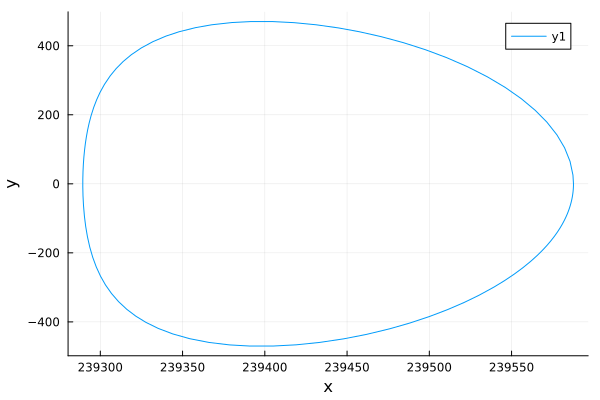

In [357]:
#this is if we rollout our dynamics with the stable initial condition
#almost periodic, can be fixed with a differential corrector
#plot(all_state_in[1,:], all_state_in[2,:], all_state_in[3,:], xlabel="x", ylabel="y", zlabel="z")

plot(all_state_final[1,:], all_state_final[2,:], xlabel="x", ylabel="y")

In [358]:
# #fix with a single shooting differential corrector
# function differential_corrector(x_0_stm, Tp)
    
#     #this is the final time it converges to
#     T_f = 0

#     #Iterate to bring the δx at T/2 to the desired state
#     max_iters = 1000

#     #keep z0 fixed and change only x0 and y_dot_0
#     for i=1:max_iters
#     #for i=1:100

#         solution = diff_solve(x_0_stm, Tp)

#         #this is the state, STM, and time when y crosses the XZ plane 
#         all_state, stm, sol_t = get_state_stm(solution)

#         #display(stm)

#         T2_state = all_state[:,end]

#         #T2_state -> x,y,z, xdot, ydot, zdot
#         #desired xdot an xzdot
#         xz_d = [0, 0]

#         rv = T2_state[1:6]

#         rv_dot = three_body_prob_dynamics_scaled(rv)

#         #desired state subtracted by state at t/2
#         δxz = xz_d - [T2_state[4], T2_state[6]]

#         #subset of the state transition matrix

#         #all 6 variables 
#         #stm_s = [stm[4,1] stm[4,3] stm[4,5]; stm[6,1] stm[6,3] stm[6,5]]

#         #to change x and ydot 

#         #keep z0 constant
#         #stm_s = [stm[4,1] stm[4,5]; stm[6,1] stm[6,5]]
#         #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,5]]

#         #keep x0 constant
#         stm_s = [stm[4,3, end] stm[4,5,end]; stm[6,3,end] stm[6,5,end]]
#         dy = [rv_dot[4]; rv_dot[6]]*[stm[2,3,end] stm[2,5,end]]


#         #println("this is stm s: ")
#         #println(stm_s)


#         #keep y0 constant
#         #stm_s = [stm[4,1] stm[4,3]; stm[6,1] stm[6,3]]
#         #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,3]]

#         delta_x0 = (stm_s - dy/rv_dot[2])\δxz
        
#         #println("THIS IS CONDITION NUMBER")
#         #println(cond((stm_s - dy/rv_dot[2])))

#         #delta_x0 = stm_s\δxz

#         #update the initial state

#         #x_0_stm[1] = x_0_stm[1] + delta_x0[1]
#         x_0_stm[3] = x_0_stm[3] + delta_x0[1]
#         x_0_stm[5] = x_0_stm[5] + delta_x0[2]

#         #x_0_stm[1:6] = x_0_stm[1:6] + delta
#         #when delta is below a set tolerance we are done

#         println("residual: ", δxz)
        
#         #loosen up the tolerance bc of the scaling of the problem
#         if norm(δxz) < 1e-6

#             #this is the total time, but we use it to ensure we have enough time to find where
#             #y crosses the xz plane
#             #print("this is sol t: ", sol_t)
#             #updating time
                    
#             T_f = sol_t[end]*2
#             break
#         end

#     end
    
#     corrected_solution = dynamics_integrate(x_0_stm, T_f)

#     all_state_final, stm_final, sol_t_final = get_state_stm(corrected_solution)
    
#     return all_state_final, stm_final, sol_t_final, corrected_solution
    
# end

In [359]:
#run the differential corrector to get the corrected solution
# all_state_final, stm_final, sol_t_final, full_solution = differential_corrector(x_0_stm, T_scaled)

In [360]:
# all_state_final

In [361]:
# sol_t_final

In [362]:
# sol_t_final[end]/time_scale

In [363]:
# all_state_final[1:3,1]/L 

In [364]:
# all_state_final[4:6]/V_

In [365]:
#Finding the unstable direction for the unstable manifold to encode as a constraint

#monodromy = stm_final[:,:,end]

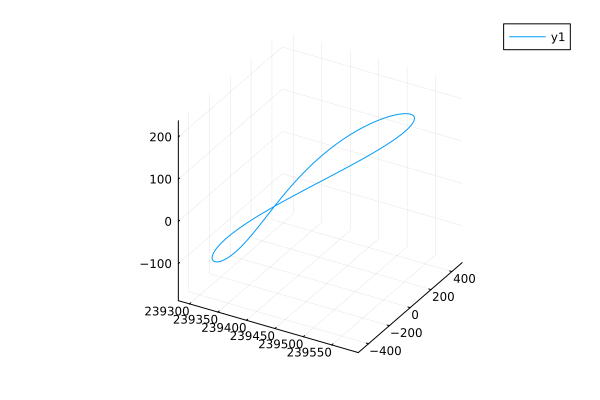

In [366]:
plot(all_state_final[1,:], all_state_final[2,:], all_state_final[3,:])

In [367]:
#using DelimitedFiles
#writedlm("xtraj.txt", all_state_final)

In [368]:
final_norm = all_state_final[:,end] - all_state_final[:,1]

6-element Vector{Float64}:
 -7.657217793166637e-8
  2.5011070260512984e-8
 -5.089333399155294e-9
 -4.817042959041947e-6
  2.3041975509840995e-6
 -8.061639399190169e-7

In [369]:
#create a 2 orbit horizon reference trajectory
periodic_initial_condition2 = all_state_final[:,1]

#Integrate the dynamics with the perturbed initial condtition
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_periodic2 = [periodic_initial_condition2; Φ_0]

#integrate for 2 revs
solution_periodic2 = dynamics_integrate(x_0_periodic2, 2*sol_t_final[end])

all_state_2, stm_in_2, sol_t_in_2 = get_state_stm(solution_periodic2)

([239587.62743544072 239587.62743348556 … 239587.46046480173 239587.6273222853; 2.885776193752321e-15 -0.06312017356234166 … 18.437032699790656 3.6617208512476916e-5; … ; -26419.73544475346 -26419.735207000682 … -26399.440003732878 -26419.732044665205; -6.138613580085994e-9 -1.3446442905795948 … 392.79064787080716 -0.001191095768596514], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000159293465 -4.904570312687886e-13 … 1.6383724254305126e-10 2.33931655307807e-15; -1.0015144263953602e-12 0.9999999952492692 … 2.3891296559661358e-6 -1.4979266363842686e-19; … ; -1.2575890383439795e-6 -0.003976955154626066 … 0.9999999858439007 -2.5079034513683386e-13; 0.0024590128797433207 -7.314235635532228e-8 … 1.779491410490773e-14 0.9999999935240685;;; 1.0000000482107467 -2.5823779973990475e-12 … 4.958593738703919e-10 1.2317082210035562e-14; -5.2732220444540605e-12 0.9999999856217405 … 4.156355291446125e-6 -1.3720891805776236e-18; … ; -3.8061389901282315e-6 -0

In [370]:
#Check when the orbit leave
periodic_initial_condition = all_state_final[:,1]

#Integrate the dynamics with the perturbed initial condtition
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_periodic = [periodic_initial_condition; Φ_0]

#integrate for 3.5 revs
solution_periodic = dynamics_integrate(x_0_stm, 4*sol_t_final[end])

all_state_lp, stm_in_lp, sol_t_in_lp = get_state_stm(solution_periodic)

([239587.62743544072 239587.62743348556 … 239324.85241372712 239319.94062322896; 2.885776193752321e-15 -0.06312017356234166 … 78.23425758960362 73.06742907010666; … ; -26419.73544475346 -26419.735207000682 … -19605.147510190858 -19399.490447240587; -6.138613580085994e-9 -1.3446442905795948 … -3357.838258399564 -3608.2889057529933], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000159293465 -4.904570312687886e-13 … 1.6383724254305126e-10 2.33931655307807e-15; -1.0015144263953602e-12 0.9999999952492692 … 2.3891296559661358e-6 -1.4979266363842686e-19; … ; -1.2575890383439795e-6 -0.003976955154626066 … 0.9999999858439007 -2.5079034513683386e-13; 0.0024590128797433207 -7.314235635532228e-8 … 1.779491410490773e-14 0.9999999935240685;;; 1.0000000482107467 -2.5823779973990475e-12 … 4.958593738703919e-10 1.2317082210035562e-14; -5.2732220444540605e-12 0.9999999856217405 … 4.156355291446125e-6 -1.3720891805776236e-18; … ; -3.8061389901282315e-6 -0.00691

In [371]:
all_state_lp

6×441 Matrix{Float64}:
      2.39588e5         2.39588e5  …       2.39325e5       2.3932e5
      2.88578e-15      -0.0631202         78.2343         73.0674
    226.168           226.168            204.542         203.619
     -5.9486e-9        -1.63672       -18251.1        -18832.1
 -26419.7          -26419.7           -19605.1        -19399.5
     -6.13861e-9       -1.34464    …   -3357.84        -3608.29

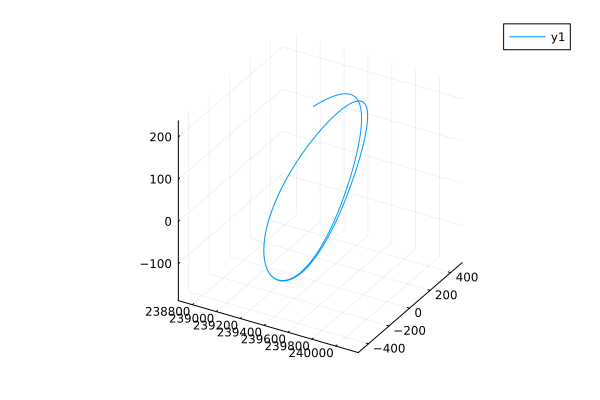

In [372]:
plot(all_state_lp[1,:], all_state_lp[2,:], all_state_lp[3,:], aspectratio=true)

In [373]:
#as seen above, after about 3.5 periods it begins to diverge from the periodic orbit 
#will formulate as a convex optimiztion problem to generate the station keeping 
#maneuvers

In [374]:
#this is the continuous dynamics
#AL2 = ForwardDiff.jacobian(x-> three_body_prob_dynamics(x), all_state_final[:,1])

In [375]:
#this is including the slack variable in the control vector
#B = [zeros(3,4); I][1:6, :]

In [376]:
nx = 6 #number of states
nu = 3 #number of controls 

3

In [377]:
sol_t_final[end ]

0.10746432599064995

In [378]:
#this is the A tilde to get the discretized dynamics
#Ã = [AL2 B; zeros(4,10)]

#this is the number of knot points in one horizon
N_period = 41  #40 knot points per period per period

#N_h = 82 #horizon 2 periods

N_h = 81 #horizon 2 periods

#this is the time step. (period T is already scaled). for 1 period
# 100 poi
Δt = (sol_t_final[end]/(N_period-1))

0.002686608149766249

In [379]:
sol_t_final[end]/time_scale

3.084590434258941

In [380]:
all_state_final[:,1]

6-element Vector{Float64}:
 239587.62743544072
      2.885776193752321e-15
    226.1684428275936
     -5.94859626923431e-9
 -26419.73544475346
     -6.138613580085994e-9

In [382]:
# custom_position_scale = norm(all_state_final[:,1])
# custom_time_scale = sol_t_final[end]
# custom_velocity_scale = custom_position_scale/custom_time_scale

In [383]:
# function get_reference(i,N)
    
#     reference = zeros(nx, N)

#     for k=1:N

#         reference[:,k] = full_solution(horizon[i:end]).u[k][1:6]
        
#     end

#     return reference
    
# end

In [384]:
#Ad = H[1:nx, 1:nx]
#Bd = H[1:nx, nx+1:end]

In [385]:
#umin = 0.5
#umax = 1

In [386]:
#N (number of knot points) 6x6 discrete dynamics jacobians

#this is along 1 period of the reference orbit
all_Ad = zeros(6,6,N_period)
all_Bd = zeros(6,3,N_period)

6×3×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 41] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [387]:
T_corrected = sol_t_final[end]

0.10746432599064995

In [388]:
horizon = LinRange(0, T_corrected, N_period)

41-element LinRange{Float64, Int64}:
 0.0, 0.00268661, 0.00537322, 0.00805982, …, 0.102091, 0.104778, 0.107464

In [389]:
horizon[2]

0.002686608149766249

In [390]:
#used to save the state transition matrix at each knot point
stm_times = zeros((6,6,N_period))

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0


In [391]:
horizon

41-element LinRange{Float64, Int64}:
 0.0, 0.00268661, 0.00537322, 0.00805982, …, 0.102091, 0.104778, 0.107464

In [392]:
solution_final.u 

155-element Vector{Vector{Float64}}:
 [239587.62743544072, 2.885776193752321e-15, 226.1684428275936, -5.94859626923431e-9, -26419.73544475346, -6.138613580085994e-9, 1.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [239587.62743348556, -0.06312017356234166, 226.1684412213288, -1.6367173765019112, -26419.735207000682, -1.3446442905795948, 1.0000000159293465, -1.0015144263953602e-12, 2.9374503103899846e-9, 0.013334853052190843  …  1.0628589266337272e-20, 0.0001371522395888422, 0.9999999858439007, 1.779491410490773e-14, 2.33931655307807e-15, -1.4979266363842686e-19, 2.3891296620824412e-6, 2.9374502948739098e-9, -2.5079034513683386e-13, 0.9999999935240685]
 [239587.62742952333, -0.10980980778570754, 226.1684379661748, -2.8473879171434753, -26419.734725186026, -2.339270042121602, 1.0000000482107467, -5.2732220444540605e-12, 8.890300247123603e-9, 0.023198568356171154  …  9.735705515670035e-20, 0.0002386029727837641, 0.9999999571560506, 9.369464155021437e-14, 1.231708

In [393]:
#get the reference trajectory
reference_trajectory = zeros(nx, N_period)

for k=1:N_period

    reference_trajectory[:,k] = solution_final(horizon).u[k][1:6]
    
    #save the reference state transition matrices at the dedicated timesteps
    
    stm_times[:,:,k] = reshape(solution_final(horizon).u[k][7:end], (6,6)) 
        
end

In [394]:
#monodromy is the stm at the end of the periodic orbit
monodromy_eigen = eigen(stm_times[:,:,end])

stable_dir = real(monodromy_eigen.vectors[:,1])
unstable_dir = real(monodromy_eigen.vectors[:,end])
#find the eigen values of the monodromy

6-element Vector{Float64}:
 -0.014154755627771133
  0.0045804331963484905
 -0.0009493005547567748
 -0.8925696587902248
  0.42532071609297856
 -0.1489948120659455

In [395]:
#save the unstable directions in a matrix
unstable_directions = zeros(6,N_period)

6×41 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [396]:
#the unstable directions are then the stm at the timestep multiplied by the unstable direction found by the monodromy

for k = 1:N_period
    
    unstable_directions[:,k] = (stm_times[:,:,k]*unstable_dir)/norm(stm_times[:,:,k]*unstable_dir)
    
end

In [397]:
#unstable directions for the unstable manifolds along the orbit
unstable_directions

6×41 Matrix{Float64}:
 -0.0141548    -0.0138869   -0.0136137   …  -0.0144143    -0.0141548
  0.00458043    0.00488325   0.00522698      0.00432203    0.00458043
 -0.000949301  -0.00115698  -0.00133631     -0.000713749  -0.000949301
 -0.89257      -0.872913    -0.851182       -0.910126     -0.89257
  0.425321      0.462972     0.501229        0.388763      0.425321
 -0.148995     -0.15317     -0.155061    …  -0.142499     -0.148995

In [398]:
#[unstable_directions[1:3, 1]; zeros(3)]

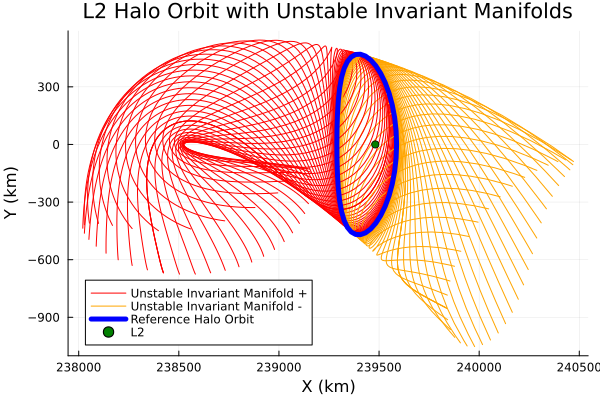

In [399]:
#plot the manifolds
#+ manifold to the right
# - manifold to the left
epz = 3
#plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Orbit")

plot(reference_trajectory[1,:], reference_trajectory[2,:], label=nothing)

all_state_mplus = 0

all_state_mminus = 0
for i=1:41

    #initial_state = reference_trajectory[:,i] + epz.*unstable_directions[:,i]

    initial_state_plus = reference_trajectory[:,i] + epz.*[unstable_directions[1:3,i];zeros(3)]

    initial_state_minus = reference_trajectory[:,i] - epz.*[unstable_directions[1:3,i];zeros(3)]

    #initial_state = reference_trajectory[:,i] - epz.*unstable_directions[:,i]

    inv_manifold_plus = just_dynamics_integrate(initial_state_plus, 1.5*sol_t_final[end])

    inv_manifold_minus = just_dynamics_integrate(initial_state_minus, 1.45*sol_t_final[end])

    all_state_mplus = get_state(inv_manifold_plus)

    all_state_mminus = get_state(inv_manifold_minus)

    #plot!(all_state_m[1,:], all_state_m[2,:], all_state_m[3,:], color="red", legend=false)

    plot!(all_state_mplus[1,:], all_state_mplus[2,:], color="red", label=nothing)
    plot!(all_state_mminus[1,:], all_state_mminus[2,:], color="orange", label=nothing)

end

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Orbit", linewidth = 5)


plot!(all_state_mplus[1,:], all_state_mplus[2,:], color="red", label = "Unstable Invariant Manifold +")
plot!(all_state_mminus[1,:], all_state_mminus[2,:], color="orange", label = "Unstable Invariant Manifold -")

plot!(reference_trajectory[1,:], reference_trajectory[2,:], label="Reference Halo Orbit", linewidth = 5, xlabel = "X (km)", ylabel = "Y (km)", color="blue")
orbit_manifolds = scatter!([XL2[1]*L], [0], markercolor = "green", label = "L2", legend=true, title = "L2 Halo Orbit with Unstable Invariant Manifolds")

#savefig(orbit_manifolds, "orbit_manifolds")

In [400]:
XL2*L 

6-element Vector{Float64}:
 239481.19345626
      0.0
      0.0
      0.0
      0.0
      0.0

In [401]:
#two orbits worth of data
unstable_constraint = cat(unstable_directions, unstable_directions, dims=2)

6×82 Matrix{Float64}:
 -0.0141548    -0.0138869   -0.0136137   …  -0.0144143    -0.0141548
  0.00458043    0.00488325   0.00522698      0.00432203    0.00458043
 -0.000949301  -0.00115698  -0.00133631     -0.000713749  -0.000949301
 -0.89257      -0.872913    -0.851182       -0.910126     -0.89257
  0.425321      0.462972     0.501229        0.388763      0.425321
 -0.148995     -0.15317     -0.155061    …  -0.142499     -0.148995

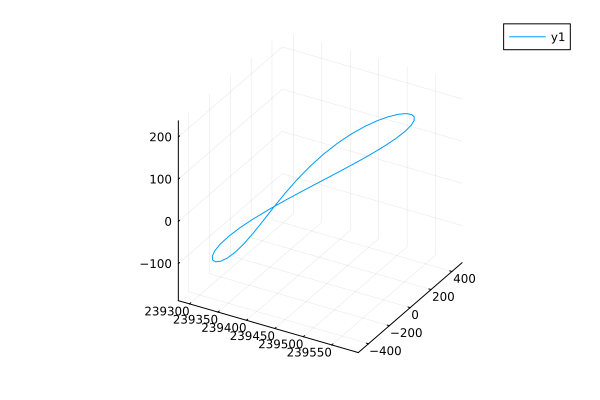

In [402]:
plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

#scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])
#scatter!([reference_trajectory[1,21]], [reference_trajectory[2,21]], [reference_trajectory[3,21]])
#scatter!([reference_trajectory[1,end]], [reference_trajectory[2,end]], [reference_trajectory[3,end]])

In [403]:
#obtain the reference trajectory at the knot points that we made up

#reference_trajectory = get_reference(1,N_period)

In [404]:
#goal is to have a look ahead of 2 orbits and apply an MPC controller 

#3 periods worth of data (just using the same orbit over the 3 periods)
#reference_trajectory_all = [reference_trajectory reference_trajectory reference_trajectory]

In [405]:
#inputs are in the custom scaled units

function three_body_prob_dynamics_wcontrol_scaled_RK4(x, u)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)
    u_original = zeros(eltype(x),3)
    
    q_original = x[1:3]/L 
    v_original = x[4:6]/V_
    u_original = u/acceleration_scale
    
    x_original = [q_original; v_original; u_original]

    ẋ_original = zeros(eltype(x),9)

    #calculate the original xdot (no scaling)

    #xoriginal is in the CR3BP units
    ẋ_original = three_body_prob_dynamics_wcontrol(x_original)

    #then scale the output
    v_scaled = ẋ_original[1:3]*V_
    
    a_scaled = ẋ_original[4:6]*acceleration_scale

    u_scaled = ẋ_original[7:9]*acceleration_scale

    ẋ_scaled = [v_scaled; a_scaled]

    return ẋ_scaled

end

three_body_prob_dynamics_wcontrol_scaled_RK4 (generic function with 1 method)

In [406]:
sol_t_final[end]

0.10746432599064995

In [407]:
#RK4 integrator with a zero order hold

function RK4_integrator(x, u)

    f1 = three_body_prob_dynamics_wcontrol_scaled_RK4(x, u)
    f2 = three_body_prob_dynamics_wcontrol_scaled_RK4(x+0.5*Δt*f1, u)
    f3 = three_body_prob_dynamics_wcontrol_scaled_RK4(x+0.5*Δt*f2, u)
    f4 = three_body_prob_dynamics_wcontrol_scaled_RK4(x+ Δt*f3, u)

    xnext = x + (Δt/6.0)*(f1+2*f2+2*f3+f4)

    return xnext

end



RK4_integrator (generic function with 1 method)

In [408]:
reference_trajectory

6×41 Matrix{Float64}:
      2.39588e5         2.39585e5  …       2.39585e5       2.39588e5
      2.88578e-15     -70.7106            70.7106          2.50111e-8
    226.168           224.14             224.14          226.168
     -5.9486e-9     -1829.05            1829.05           -4.82299e-6
 -26419.7          -26119.7           -26119.7        -26419.7
     -6.13861e-9    -1508.04       …    1508.04           -8.12303e-7

In [409]:
u0 = zeros(3)
Ak_rk4 = ForwardDiff.jacobian(x_-> RK4_integrator(x_, u0), reference_trajectory[:,1])

6×6 Matrix{Float64}:
  1.02015     -0.000696091   0.00370582  …  0.000206734   3.31474e-6
 -0.00142523   0.994037     -0.00027359     0.00267059   -2.38997e-7
  0.00371632  -8.25675e-5    0.991821       1.69488e-8    0.00267927
 15.0058      -0.776788      2.75236        0.153571      0.00369167
 -1.59281     -4.40607      -0.304876       0.982132     -0.000355057
  2.76794     -0.0920887    -6.08133     …  2.59774e-5    0.991814

In [410]:
Bk_rk4 = ForwardDiff.jacobian(u_-> RK4_integrator(reference_trajectory[:,1], u_), u0)

6×3 Matrix{Float64}:
  3.6139e-6     1.85183e-7    2.23021e-9
 -1.85886e-7    3.59817e-6   -7.46841e-11
  2.23021e-9   -7.46841e-11   3.604e-6
  0.002694      0.000206472   3.30443e-6
 -0.000208038   0.00267059   -2.93532e-7
  3.3172e-6    -3.83812e-8    0.00267926

In [411]:
for i=1:N_period

    #get the discrete dynamics jacobians for the entire reference trajectory along the knot points

    #Ak = ForwardDiff.jacobian(x-> three_body_prob_dynamics_scaled(x), reference_trajectory[:,i])
    all_Ad[:,:,i] = ForwardDiff.jacobian(x_-> RK4_integrator(x_, zeros(3)), reference_trajectory[:,i])

    #this is including the slack variable in the control vector (this is control on accelerations/thrust)
    #Bk = [zeros(3,3); I]

    all_Bd[:,:,i] = ForwardDiff.jacobian(u_-> RK4_integrator(reference_trajectory[:,i], u_), zeros(3))

    #this is the A tilde to get the discretized dynamics
    # Ãk = [Ak Bk; zeros(3,9)]

    # H = exp(Ãk*Δt)

    # all_Ad[:,:,i] = H[1:nx, 1:nx]

    # all_Bd[:,:,i] = H[1:nx, nx+1:end]
    
    
end

In [412]:
all_Bd[:,:,1]

6×3 Matrix{Float64}:
  3.6139e-6     1.85183e-7    2.23021e-9
 -1.85886e-7    3.59817e-6   -7.46841e-11
  2.23021e-9   -7.46841e-11   3.604e-6
  0.002694      0.000206472   3.30443e-6
 -0.000208038   0.00267059   -2.93532e-7
  3.3172e-6    -3.83812e-8    0.00267926

In [413]:
all_Ad[:,:,1] 

6×6 Matrix{Float64}:
  1.02015     -0.000696091   0.00370582  …  0.000206734   3.31474e-6
 -0.00142523   0.994037     -0.00027359     0.00267059   -2.38997e-7
  0.00371632  -8.25675e-5    0.991821       1.69488e-8    0.00267927
 15.0058      -0.776788      2.75236        0.153571      0.00369167
 -1.59281     -4.40607      -0.304876       0.982132     -0.000355057
  2.76794     -0.0920887    -6.08133     …  2.59774e-5    0.991814

In [414]:
all_Ad_1 = cat(all_Ad, all_Ad[:,:,2:end], dims=3)
all_Bd_1 = cat(all_Bd, all_Bd[:,:,2:end], dims=3)

6×3×81 Array{Float64, 3}:
[:, :, 1] =
  3.6139e-6     1.85183e-7    2.23021e-9
 -1.85886e-7    3.59817e-6   -7.46841e-11
  2.23021e-9   -7.46841e-11   3.604e-6
  0.002694      0.000206472   3.30443e-6
 -0.000208038   0.00267059   -2.93532e-7
  3.3172e-6    -3.83812e-8    0.00267926

[:, :, 2] =
  3.61385e-6    1.8449e-7     2.1907e-9
 -1.86579e-7    3.59825e-6   -2.18877e-10
  2.1907e-9    -2.18877e-10   3.60397e-6
  0.0026939     0.000205448   3.22311e-6
 -0.000209066   0.00267074   -5.01936e-7
  3.25212e-6   -2.52418e-7    0.00267921

[:, :, 3] =
  3.61374e-6    1.83819e-7    2.11365e-9
 -1.8725e-7     3.59841e-6   -3.49645e-10
  2.11365e-9   -3.49645e-10   3.60392e-6
  0.00269372    0.000204462   3.08785e-6
 -0.000210059   0.002671     -6.85184e-7
  3.13133e-6   -4.45518e-7    0.00267912

;;; … 

[:, :, 79] =
  3.61385e-6   1.86576e-7   2.19073e-9
 -1.84493e-7   3.59825e-6   2.18328e-10
  2.19073e-9   2.18328e-10  3.60397e-6
  0.00269396   0.000208554  3.29185e-6
 -0.000205958  0.00

In [415]:
#concatenate jacobians for two periods

# all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
# all_Bd_1 = cat(all_Bd, all_Bd, dims=3)

In [416]:
N_period

41

In [417]:
num_revs = 10

10

In [418]:
#1 revolution is 14 days
T*time_scale/60/60/24

1.2438000693362261e-6

In [419]:
T*time_scale

0.10746432599064995

In [420]:
N_h

81

In [421]:
#compute backward ricatti recursion

#cost to go matrices
#P = zeros((6,6,N_period*num_revs)) #size state x state (6x6) 
#K = zeros((3,6,N_period*num_revs)) #size control x state (3x6)

#cost to go matrices for 16 revs
P = zeros((6,6,N_period+((N_period-1)*15))) #size state x state (6x6) 
K = zeros((3,6,N_period+((N_period-1)*15))) #size control x state (3x6)

#state cost weight matrix
Q = 1.0*Matrix(I,6,6).*1e-6

#terminal cost weight matrix
Qf = 1.0*Matrix(I,6,6).*1e-6

#control cost weight matrix
R = 1.0*Matrix(I,3,3).*1e-3

3×3 Matrix{Float64}:
 0.001  0.0    0.0
 0.0    0.001  0.0
 0.0    0.0    0.001

In [422]:
N_period+((N_period-1)*15)

641

In [423]:
P

6×6×641 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 639] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 640] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0

In [424]:
#1:(N_period*num_revs) - 1

In [425]:
#all_Ad_rev = all_Ad

In [426]:
all_Ad_16 = all_Ad
all_Bd_16 = all_Bd

6×3×41 Array{Float64, 3}:
[:, :, 1] =
  3.6139e-6     1.85183e-7    2.23021e-9
 -1.85886e-7    3.59817e-6   -7.46841e-11
  2.23021e-9   -7.46841e-11   3.604e-6
  0.002694      0.000206472   3.30443e-6
 -0.000208038   0.00267059   -2.93532e-7
  3.3172e-6    -3.83812e-8    0.00267926

[:, :, 2] =
  3.61385e-6    1.8449e-7     2.1907e-9
 -1.86579e-7    3.59825e-6   -2.18877e-10
  2.1907e-9    -2.18877e-10   3.60397e-6
  0.0026939     0.000205448   3.22311e-6
 -0.000209066   0.00267074   -5.01936e-7
  3.25212e-6   -2.52418e-7    0.00267921

[:, :, 3] =
  3.61374e-6    1.83819e-7    2.11365e-9
 -1.8725e-7     3.59841e-6   -3.49645e-10
  2.11365e-9   -3.49645e-10   3.60392e-6
  0.00269372    0.000204462   3.08785e-6
 -0.000210059   0.002671     -6.85184e-7
  3.13133e-6   -4.45518e-7    0.00267912

;;; … 

[:, :, 39] =
  3.61385e-6   1.86576e-7   2.19073e-9
 -1.84493e-7   3.59825e-6   2.18328e-10
  2.19073e-9   2.18328e-10  3.60397e-6
  0.00269396   0.000208554  3.29185e-6
 -0.000205958  0.00

In [427]:
for i = 2:16
    all_Ad_16 = cat(all_Ad_16, all_Ad[:,:,2:end], dims = 3)
    all_Bd_16 = cat(all_Bd_16, all_Bd[:,:,2:end], dims = 3)
end


In [428]:
# all_Ad_4 = cat(all_Ad_1, all_Ad_1, dims=3)
# all_Bd_4 = cat(all_Bd_1, all_Bd_1, dims=3)

# all_Ad_8 = cat(all_Ad_4, all_Ad_4, dims=3)
# all_Bd_8 = cat(all_Bd_4, all_Bd_4, dims=3)

# all_Ad_16 = cat(all_Ad_8, all_Ad_8, dims=3)
# all_Bd_16 = cat(all_Bd_8, all_Bd_8, dims=3)

In [429]:
# for i = 1:num_revs
#     all_Ad_rev = (all_Ad_rev, all_Ad, dims=3)
# end

In [430]:
# P[:,:,end] = Qf

# for k = reverse(1:(N_period*num_revs) - 1)
    
#     K[:,:,k] = (R + all_Bd_1[:,:,k]'*P[:,:,k+1]*all_Bd_1[:,:,k])\(all_Bd_1[:,:,k]'*P[:,:,k+1]*all_Ad_1[:,:, k]) # ricatti recursion for both A and B matrices changing
#     P[:,:,k] = Q + all_Ad_1[:,:,k]'*P[:,:,k+1]*all_Ad_1[:,:,k] - all_Ad_1[:,:,k]'*P[:,:,k+1]*all_Bd_1[:,:,k]*K[:,:,k]
 
# end 

In [431]:
#Ricatti recursion over 2 periods
P[:,:,end] = Qf

for k = reverse(1:640)
    #println(k)    
    K[:,:,k] = (R + all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k])\(all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:, k]) # ricatti recursion for both A and B matrices changing
    P[:,:,k] = Q + all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:,k] - all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k]*K[:,:,k]
        
end

In [432]:
P

6×6×641 Array{Float64, 3}:
[:, :, 1] =
      2.90185e5  -97251.6      37416.7     3554.66    1150.27      238.422
 -97251.6         32593.2     -12540.0    -1191.3     -385.487     -79.8903
  37416.7        -12540.0       4825.22     458.347    148.311      30.722
   3554.66        -1191.3        458.347     43.5437    14.0898      2.9202
   1150.27         -385.487      148.311     14.0898     4.5608      0.945341
    238.422         -79.8903      30.722      2.9202     0.945341    0.197795

[:, :, 2] =
     2.83171e5      -1.07259e5  …   3524.05    1056.66      174.525
    -1.07259e5   40627.9           -1334.84    -400.219     -66.0905
 34838.6        -13196.2             433.567    129.997      21.463
  3524.05        -1334.84             43.8569    13.1495      2.1716
  1056.66         -400.219            13.1495     3.94418     0.651523
   174.525         -66.0905     …      2.1716     0.651523    0.109544

[:, :, 3] =
     2.76539e5      -1.16154e5   31815.5    …   978.652     1

In [433]:
P[:,:,1]

6×6 Matrix{Float64}:
      2.90185e5  -97251.6      37416.7     3554.66    1150.27      238.422
 -97251.6         32593.2     -12540.0    -1191.3     -385.487     -79.8903
  37416.7        -12540.0       4825.22     458.347    148.311      30.722
   3554.66        -1191.3        458.347     43.5437    14.0898      2.9202
   1150.27         -385.487      148.311     14.0898     4.5608      0.945341
    238.422         -79.8903      30.722      2.9202     0.945341    0.197795

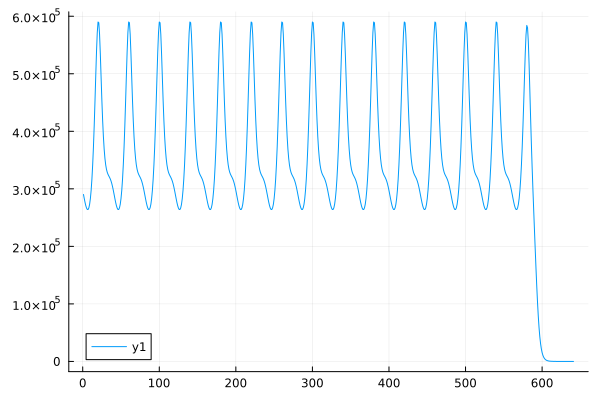

In [434]:
plot(P[1,1,:])
#plot(P[2,2,:])
#plot(P[3,3,:])
#plot(P[4,4,:])
#plot(P[5,5,:])
#plot(P[6,6,:])

In [435]:
#cost to go converges and is periodic! will get one orbit of the cost to go to make a constraint
V = P[:,:,1:41]

6×6×41 Array{Float64, 3}:
[:, :, 1] =
      2.90185e5  -97251.6      37416.7     3554.66    1150.27      238.422
 -97251.6         32593.2     -12540.0    -1191.3     -385.487     -79.8903
  37416.7        -12540.0       4825.22     458.347    148.311      30.722
   3554.66        -1191.3        458.347     43.5437    14.0898      2.9202
   1150.27         -385.487      148.311     14.0898     4.5608      0.945341
    238.422         -79.8903      30.722      2.9202     0.945341    0.197795

[:, :, 2] =
     2.83171e5      -1.07259e5  …   3524.05    1056.66      174.525
    -1.07259e5   40627.9           -1334.84    -400.219     -66.0905
 34838.6        -13196.2             433.567    129.997      21.463
  3524.05        -1334.84             43.8569    13.1495      2.1716
  1056.66         -400.219            13.1495     3.94418     0.651523
   174.525         -66.0905     …      2.1716     0.651523    0.109544

[:, :, 3] =
     2.76539e5      -1.16154e5   31815.5    …   978.652     10

In [436]:
V[:,:,1]

6×6 Matrix{Float64}:
      2.90185e5  -97251.6      37416.7     3554.66    1150.27      238.422
 -97251.6         32593.2     -12540.0    -1191.3     -385.487     -79.8903
  37416.7        -12540.0       4825.22     458.347    148.311      30.722
   3554.66        -1191.3        458.347     43.5437    14.0898      2.9202
   1150.27         -385.487      148.311     14.0898     4.5608      0.945341
    238.422         -79.8903      30.722      2.9202     0.945341    0.197795

In [437]:
#cost to go matrices for 2 orbits worth of data
V_2orbits = cat(V, V[:,:,2:end], dims=3)

6×6×81 Array{Float64, 3}:
[:, :, 1] =
      2.90185e5  -97251.6      37416.7     3554.66    1150.27      238.422
 -97251.6         32593.2     -12540.0    -1191.3     -385.487     -79.8903
  37416.7        -12540.0       4825.22     458.347    148.311      30.722
   3554.66        -1191.3        458.347     43.5437    14.0898      2.9202
   1150.27         -385.487      148.311     14.0898     4.5608      0.945341
    238.422         -79.8903      30.722      2.9202     0.945341    0.197795

[:, :, 2] =
     2.83171e5      -1.07259e5  …   3524.05    1056.66      174.525
    -1.07259e5   40627.9           -1334.84    -400.219     -66.0905
 34838.6        -13196.2             433.567    129.997      21.463
  3524.05        -1334.84             43.8569    13.1495      2.1716
  1056.66         -400.219            13.1495     3.94418     0.651523
   174.525         -66.0905     …      2.1716     0.651523    0.109544

[:, :, 3] =
     2.76539e5      -1.16154e5   31815.5    …   978.652     10

In [438]:
V_first = V_2orbits[:,:,1]

6×6 Matrix{Float64}:
      2.90185e5  -97251.6      37416.7     3554.66    1150.27      238.422
 -97251.6         32593.2     -12540.0    -1191.3     -385.487     -79.8903
  37416.7        -12540.0       4825.22     458.347    148.311      30.722
   3554.66        -1191.3        458.347     43.5437    14.0898      2.9202
   1150.27         -385.487      148.311     14.0898     4.5608      0.945341
    238.422         -79.8903      30.722      2.9202     0.945341    0.197795

In [439]:
V_first'

6×6 adjoint(::Matrix{Float64}) with eltype Float64:
      2.90185e5  -97251.6      37416.7     3554.66    1150.27      238.422
 -97251.6         32593.2     -12540.0    -1191.3     -385.487     -79.8903
  37416.7        -12540.0       4825.22     458.347    148.311      30.722
   3554.66        -1191.3        458.347     43.5437    14.0898      2.9202
   1150.27         -385.487      148.311     14.0898     4.5608      0.945341
    238.422         -79.8903      30.722      2.9202     0.945341    0.197795

In [440]:
difference = V_first - V_first'

6×6 Matrix{Float64}:
  0.0           1.60071e-10   1.09139e-10  …  4.09273e-12   5.05906e-12
 -1.60071e-10   0.0          -8.54925e-11     1.25056e-12  -1.13687e-12
 -1.09139e-10   8.54925e-11   0.0             2.41585e-12  -4.67537e-12
 -1.36424e-12   2.27374e-12   1.81899e-12     3.55271e-14   1.22125e-13
 -4.09273e-12  -1.25056e-12  -2.41585e-12     0.0          -1.12799e-13
 -5.05906e-12   1.13687e-12   4.67537e-12  …  1.12799e-13   0.0

In [441]:
difference2 = V_2orbits[:,:,2] - V_2orbits[:,:,2]'

6×6 Matrix{Float64}:
  0.0           1.74623e-10   1.52795e-10  …  3.63798e-12   5.05906e-12
 -1.74623e-10   0.0          -1.21872e-10     9.66338e-13  -2.13163e-12
 -1.52795e-10   1.21872e-10   0.0             3.06954e-12  -4.76774e-12
 -1.36424e-12   2.72848e-12   2.04636e-12     3.55271e-14   1.1191e-13
 -3.63798e-12  -9.66338e-13  -3.06954e-12     0.0          -1.1191e-13
 -5.05906e-12   2.13163e-12   4.76774e-12  …  1.1191e-13    0.0

In [442]:
symmetric_v1 = (V_first + V_first')/2

6×6 Matrix{Float64}:
      2.90185e5  -97251.6      37416.7     3554.66    1150.27      238.422
 -97251.6         32593.2     -12540.0    -1191.3     -385.487     -79.8903
  37416.7        -12540.0       4825.22     458.347    148.311      30.722
   3554.66        -1191.3        458.347     43.5437    14.0898      2.9202
   1150.27         -385.487      148.311     14.0898     4.5608      0.945341
    238.422         -79.8903      30.722      2.9202     0.945341    0.197795

In [443]:
#needed for the quadratic constraint
invsymmetricv1 = inv(symmetric_v1)

6×6 Matrix{Float64}:
    61.4635     20.2739      4.014    …  -1840.05        -648.708
    20.2739      8.63147     1.82332      -598.493       -214.395
     4.014       1.82332     2.57891      -122.371        -23.2529
 -3866.21    -1230.06     -263.786           1.15787e5  40603.9
 -1840.05     -598.493    -122.371       55778.6        19238.8
  -648.708    -214.395     -23.2529   …  19238.8         7557.77

In [444]:
invsymmetricv1 - invsymmetricv1'

6×6 Matrix{Float64}:
  0.0          -2.21619e-9   -1.95185e-10  …  -3.60819e-9   3.11877e-9
  2.21619e-9    0.0           7.90723e-11     -6.75873e-8  -2.23689e-8
  1.95185e-10  -7.90723e-11   0.0             -6.06531e-9  -1.85831e-9
  5.76192e-8    1.5838e-7     1.601e-8        -1.4995e-6   -8.04408e-7
  3.60819e-9    6.75873e-8    6.06531e-9       0.0         -1.31691e-7
 -3.11877e-9    2.23689e-8    1.85831e-9   …   1.31691e-7   0.0

In [445]:
display(V_first)

6×6 Matrix{Float64}:
      2.90185e5  -97251.6      37416.7     3554.66    1150.27      238.422
 -97251.6         32593.2     -12540.0    -1191.3     -385.487     -79.8903
  37416.7        -12540.0       4825.22     458.347    148.311      30.722
   3554.66        -1191.3        458.347     43.5437    14.0898      2.9202
   1150.27         -385.487      148.311     14.0898     4.5608      0.945341
    238.422         -79.8903      30.722      2.9202     0.945341    0.197795

In [446]:
#far_deviation = [1, 0, 1, 0, 1, 0]

In [447]:
#cost to go for this far deviation
#far_deviation'*inv(V_first)*far_deviation

In [448]:
#get the initial delta x
#this is some noise on the reference trajectory

#some arbitrary deviation from the reference trajectory
#x_initial_ref = [1e-4, 1e-4, 1e-4, 1e-5, 1e-5, 1e-5]

#this is working
#x_initial_ref = [1e-9, 0, 0, 0, 1e-9, 0]

#this is working. Pretty far deviation in x = 385 km, and vy off by ~1e-3 km/s
#x_initial_ref = [1e-3, 0, 0, 0, 1e-3, 0]


#off by 385 km meters and ~1 mm/s

#x_initial_ref = [1e-3, 0, 0, 0, 1e-6, 0]


#try a small deviation
#works great with a small deviation
#x_initial_ref = [1e-9, 0, 0, 0, 1e-9, 0]

#trying a larger deviation
#these are in CR3BP units
x_initial_ref = [1e-6, 0, 0, 0, 1e-6, 0]

x_initial_ref_scaled = [x_initial_ref[1:3]*L; x_initial_ref[4:6]*V_]

#ensure that the initial deviation is in the unstable manifold direction
#x_initial_ref = [1e-9, -1e-9, 1e-9, 1e-9, -1e-9, 1e-9]

6-element Vector{Float64}:
 0.238529
 0.0
 0.0
 0.0
 6.84659085618205
 0.0

In [449]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.238529
 0.0
 0.0
 0.0
 6.84659085618205
 0.0

In [450]:
x_initial_ref_scaled'*V[:,:,1]*x_initial_ref_scaled

20481.18555054609

In [451]:
V[:,:,20]

6×6 Matrix{Float64}:
      5.90015e5  -58587.5     …  4329.35     3702.34     -618.525
 -58587.5          5818.31       -429.887    -367.649      61.4082
     -1.01632e5   10092.0        -745.756    -637.745     106.514
   4329.35         -429.887        31.7678     27.1662     -4.53846
   3702.34         -367.649        27.1662     23.2329     -3.88098
   -618.525          61.4082  …    -4.53846    -3.88098     0.649392

In [452]:
V[:,:,end]

6×6 Matrix{Float64}:
      2.90184e5  -97251.5      37416.6     …  1150.27      238.421
 -97251.5         32593.1     -12539.9        -385.49      -79.8916
  37416.6        -12539.9       4825.19        148.312      30.7225
   3554.66        -1191.3        458.346        14.0899      2.92024
   1150.27         -385.49       148.312         4.56066     0.945267
    238.421         -79.8916      30.7225  …     0.945267    0.19763

In [453]:
test = eigen(V[:,:,20]).values

6-element Vector{Float64}:
      3.0329076475167508e-6
      0.0004144042923729866
      0.0006763026519755771
      0.6566660513797736
      1.720420857054722
 613395.2818314692

In [454]:
1/sqrt(test[6])

0.0012768203164339118

In [455]:
#concatenate unstable directions for 2 orbits

unstable_directions_2 = cat(unstable_directions, unstable_directions[:, 2:end], dims=2)

6×81 Matrix{Float64}:
 -0.0141548    -0.0138869   -0.0136137   …  -0.0144143    -0.0141548
  0.00458043    0.00488325   0.00522698      0.00432203    0.00458043
 -0.000949301  -0.00115698  -0.00133631     -0.000713749  -0.000949301
 -0.89257      -0.872913    -0.851182       -0.910126     -0.89257
  0.425321      0.462972     0.501229        0.388763      0.425321
 -0.148995     -0.15317     -0.155061    …  -0.142499     -0.148995

In [456]:
# V_2orbits

In [458]:
#works decent with 15 and 15
#these work good
tube_pose_r = 1
tube_vel_r = 20

20

In [459]:
x_initial_ref[:,1]

6-element Vector{Float64}:
 1.0e-6
 0.0
 0.0
 0.0
 1.0e-6
 0.0

In [460]:
# c_test= unstable_directions[:,1]/tan(pi/6)

# manifold_constraint_test = norm(x_initial_ref[:,1]) - c_test'*(x_initial_ref[:,1])

In [461]:
# dot(x_initial_ref[:,1], unstable_directions[:,1])

In [462]:
# dot(reference_trajectory[:,1] + x_initial_ref, unstable_directions[:,1])

In [463]:
# test = (reference_trajectory[:,1] + x_initial_ref)/norm(reference_trajectory[:,1] + x_initial_ref)

In [464]:
# dot(test, unstable_directions[:,1])

In [465]:
# L

In [466]:
# dot(x_initial_ref, unstable_directions[:,1])

In [467]:
all_Ad

6×6×41 Array{Float64, 3}:
[:, :, 1] =
  1.02015     -0.000696091   0.00370582  …  0.000206734   3.31474e-6
 -0.00142523   0.994037     -0.00027359     0.00267059   -2.38997e-7
  0.00371632  -8.25675e-5    0.991821       1.69488e-8    0.00267927
 15.0058      -0.776788      2.75236        0.153571      0.00369167
 -1.59281     -4.40607      -0.304876       0.982132     -0.000355057
  2.76794     -0.0920887    -6.08133     …  2.59774e-5    0.991814

[:, :, 2] =
  1.02001     -0.00184642    0.00363856   …   0.000205704   3.24762e-6
 -0.00257715   0.99421      -0.000512787      0.00267071   -4.51814e-7
  0.00366136  -0.000324786   0.991786        -2.00404e-7    0.00267923
 14.8698      -1.62786       2.68976          0.152425      0.0036031
 -2.44585     -4.23881      -0.479556         0.98229      -0.000588374
  2.71888     -0.270616     -6.1127       …  -0.000214923   0.991765

[:, :, 3] =
  1.01979     -0.00295756    0.00350921   …   0.000204708   3.12539e-6
 -0.00369204   0.994509     

In [468]:
#this is the reference trajectory for 2 orbits starting at the beginning
reference_trajectory2 = [reference_trajectory reference_trajectory[:,2:end]]

6×81 Matrix{Float64}:
      2.39588e5         2.39585e5  …       2.39585e5       2.39588e5
      2.88578e-15     -70.7106            70.7106          2.50111e-8
    226.168           224.14             224.14          226.168
     -5.9486e-9     -1829.05            1829.05           -4.82299e-6
 -26419.7          -26119.7           -26119.7        -26419.7
     -6.13861e-9    -1508.04       …    1508.04           -8.12303e-7

In [469]:
reference_trajectory_half = cat(reference_trajectory[:,21:end], reference_trajectory[:,2:21], dims=2)

#this is the reference trajectory starting at the half 21
reference_trajectory2_2 = cat(reference_trajectory_half, reference_trajectory_half[:,2:end], dims=2)

6×81 Matrix{Float64}:
     2.39289e5       2.3929e5      2.39292e5  …      2.3929e5      2.39289e5
    -1.11574e-7     80.0752      157.408           -80.0752       -1.11574e-7
  -175.727        -172.391      -162.594          -172.391      -175.727
     1.84934e-5    541.06       1188.98           -541.062         1.84934e-5
 29978.8         29460.0       27953.6           29460.0       29978.8
    -1.43134e-5   2469.86       4786.75       …  -2469.85         -1.43134e-5

In [470]:
#get the reference trajectory when you are starting at the half


In [471]:
#dynamics_wcontrol_integrate([reference_trajectory2[:,1]; zeros(3)], Δt).u[end][1:6]

In [472]:
#cost to go level set
#works with 0.1

#THIS EPSILON IS WORKING
#epsilon = 1

#going to have to tune this...
epsilon = 1

umax = 0.025

0.025

In [473]:
x_initial_ref'*P[:,:,1]*x_initial_ref

2.924896414494457e-7

In [474]:
P[:,:,end]

6×6 Matrix{Float64}:
 1.0e-6  0.0     0.0     0.0     0.0     0.0
 0.0     1.0e-6  0.0     0.0     0.0     0.0
 0.0     0.0     1.0e-6  0.0     0.0     0.0
 0.0     0.0     0.0     1.0e-6  0.0     0.0
 0.0     0.0     0.0     0.0     1.0e-6  0.0
 0.0     0.0     0.0     0.0     0.0     1.0e-6

In [475]:
P[:,:,1]

6×6 Matrix{Float64}:
      2.90185e5  -97251.6      37416.7     3554.66    1150.27      238.422
 -97251.6         32593.2     -12540.0    -1191.3     -385.487     -79.8903
  37416.7        -12540.0       4825.22     458.347    148.311      30.722
   3554.66        -1191.3        458.347     43.5437    14.0898      2.9202
   1150.27         -385.487      148.311     14.0898     4.5608      0.945341
    238.422         -79.8903      30.722      2.9202     0.945341    0.197795

In [476]:
#lower bound as 10 mm/s. Converting to an acceleration based off of our discretization as well as the units that we are using which 
#is km/day
lower_bound = 10/(Δt*86400)*(86400^2/1e6)

321.59509382682893

In [477]:
# #10 mm/s
# Tmin = lower_bound
# #1 m/s
# Tmax = 100*lower_bound

In [478]:
#formulate the problem at every solve


#pass in the initial condition, along with jacobians of the current reference trajectory 

#bias is a 6xN_h-1 matrix
function update_prob(x_initial_k, all_Ad_k, all_Bd_k, P_k, unstable_directions_k, bias, reference_traj_k)
    
    #clear the constraints and decision variables every run
    #cons = 0
    #U = 0
    
    X = Variable(nx,N_h)
        
    U = Variable(nu, N_h-1)
    
    #initial state constraint
    cons = Constraint[X[:,1] == x_initial_k]

    #state constraints
    #Dynamics constraint (for the entire horizon)
    
    # for k=1:(N_h-1)
    #     #these are the dynamics for delta x
        
    #     #all_Ad_k will have the 120 jacobians that are associated to the reference trajectory at the moment. 
        
    #     push!(cons, X[:,k+1] == all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k])
    # end


    #dynamics constraint with bias
    for k=1:(N_h-1)
        #these are the dynamics for delta x
        
        #all_Ad_k will have the 120 jacobians that are associated to the reference trajectory at the moment. 
        #check sign on the bias. parenthesis
        #push!(cons, zeros(6)== X[:,k+1] - all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k] - bias[:,k])
        
        #kinda working
        #push!(cons, zeros(6)== X[:,k+1] - (all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k]) - bias[:,k])

        #Linear affine term in terms of Δx and Δu (the integrator is there because the reference trajectory is not dynamically feasible)
        #(x̄+Δx) - (f(x̄,ū) + AΔx + BΔu) - bias
        push!(cons, zeros(6)== reference_traj_k[:,k+1] + X[:,k+1] - (dynamics_wcontrol_integrate([reference_traj_k[:,k]; zeros(3)], Δt).u[end][1:6] + all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[1:3,k]) - bias[:,k])

        
        #in terms of x's
        #prob.constraints += X[:,i+1] == rk4(model, dynamics, X̄[i], Ū[i], params.dt) + A[i]*(X[:,i] - X̄[i]) + B[i]*(U[:,i] - Ū[i])
        #in terms of deltas
        #prob.constraints += X̄[i+1] + ΔX[:,i+1] == rk4(model, dynamics, X̄[i], Ū[i], params.dt) + A[i]*ΔX[:,i] + B[i]*ΔU[:,i]


    end

    
    #already propagating the deltas since we are linearizing the dynamics about the reference trajectories
    
#     for k=1:(N_h-1)        
#         #Box constraints on the deviation from the reference trajectory
                
#         push!(cons, X[1,k] <= xmax)
#         push!(cons, X[1,k] >= -xmax)
#         push!(cons, X[2,k] <= ymax)
#         push!(cons, X[2,k] >= -ymax)
#         push!(cons, X[3,k]<= zmax)
#         push!(cons, X[3,k] >= -zmax)
         
#     end
    
    
    #tube constraint
    #for k=2:(N_h-1) #this was there before and works
    #THIS WORKS and gives nice impluses. removes the noise. HIGH tube pose r
    for k=1:N_h 
       push!(cons, norm(X[1:3,k],2) <= tube_pose_r)
    
       push!(cons, norm(X[4:6,k],2) <= tube_vel_r)
         
    end
    
    
    #cost to go constraint (Working, most current)
    # for k=2:N_h
        
    #    costtogo = P_k[:,:,k]
        
    #    costtogo_hermitian = (costtogo + costtogo')/2
        
    #    #relaxing bc of the manifold constraint
    #    ctg_constraint = quadform(X[:,k], costtogo_hermitian) <= epsilon
        
    #    push!(cons, ctg_constraint)
                
    # end
    
    #manifold constraint (useful)
    #the delta x needs to be normalized
    #exits to the left with the negative sending
    #this is what is used. for some reason it is being infeasbile in problem 2
   #for k=1:N_h
#     for k=2:N_h 
        
#       #this works the best. investigate why 
#       #manifold goes to the left.  (w no ctg constraint)
#       #manifold_constraint = dot(X[:,k], unstable_directions_k[:,k])
        
#       #push!(cons, manifold_constraint >= 0.5*norm(X[:,k]))
        
        
#       #testing  (working) 
#       #goes left with positive unstable direction
#       manifold_constraint = dot(X[:,k], 1*unstable_directions_k[:,k])
        
#       #push!(cons, manifold_constraint >= 0.1*norm(X[:,k]))

#       #push!(cons, manifold_constraint >= 0)

#       #trying out 
#       push!(cons, manifold_constraint > 0)

                
        
#    end



#this is working
for k = 2:N_h
#to have this at 1, the initial deviation has to satisfy this constraint off the bat. 
#for k = 1:N_h
            
    #manifold goes to the right
    #manifold_constraint = dot(X[:,k], unstable_directions_k[:,k])
    manifold_constraint = X[:,k]'*unstable_directions_k[:,k]
    
    #currently working
    #push!(cons, manifold_constraint > 0)

    #add some slack (works with the positive stable directions. negative stable directions still some that don't satisfy fully)
    #push!(cons, manifold_constraint > 1e-6)

    #will try bumping up the slack (tried 1e-5, worked better but not 100%)
    #1e-4 works good 
    #works good 1e-3
    #works with 1e-1 but at a higher cost
    push!(cons, manifold_constraint > 1e-2)

    
end




   #manifold glideslope constraint for the whole unstable direction

#    for k=2:N_h
#     for k=1:N_h

#         #works with pi/5 too
#         c = unstable_directions_k[:,k]/tan(pi/6)

#         manifold_constraint = norm(X[:,k]) - c'*(X[:,k])

#         push!(cons, manifold_constraint <= 0)

#    end

#currently the one being used
# for k=2:N_h
        
#     #works with pi/5 too
#     c = unstable_directions_k[:,k]/tan(pi/6)
#     #c = unstable_directions_k[:,k]/tan((pi/2) - deg2rad(60)

#     manifold_constraint = norm(X[:,k]) - c'*X[:,k]

#     push!(cons, manifold_constraint <= 0)

# end

    
     
    #Controls Constraint
    #convexification constraint

    # for k=1:(N_h-1)

    #     push!(cons, Tmin <= U[1,k])
    #     push!(cons, Tmin <= U[2,k])
    #     push!(cons, Tmin <= U[3,k])

    # end
    
    #not working
    # for k=1:(N_h-1)

    #     σ1 = U[4,k]

    #     push!(cons, Tmin <= σ1)

    #     push!(cons, norm(U[1:3, k]) <= min(σ1, Tmax))

    # end
        
    #    push!(cons, U[1:3, k]> umin)
        
        
        #not working
        #σ = U[4,k]
        
        #convexified non convex constraint lower bound
        #push!(cons, umin <= σ)
        
        #convexified non convex constraint upper bound
        #push!(cons, σ <= umax)
        
        #convex upper bound on the thrust norm
        #push!(cons, norm(U[1:3,k]) <= σ)
        
        
        #upper bound
        #push!(cons, norm(U[1:3,k]) <= min(σ, umax))
        
        
    #end
    
    #print("done")
    
    return cons, X, U
        
end

update_prob (generic function with 1 method)

In [479]:
unstable_directions[:,1]

6-element Vector{Float64}:
 -0.014154755627771133
  0.0045804331963484905
 -0.0009493005547567748
 -0.8925696587902248
  0.42532071609297856
 -0.1489948120659455

In [480]:
#create the optimization problem

function solve_opt(cons, X, U, N)
    
    #these are tuning parameters
    
    #controls how tight you are tracking the reference 
    #α = 1e3
    
    #controls how much control effort you want to use (high value = low control)
    #β = 1e6
    #β = [1e6, 1e6, 1e15]
    #β = [1e3, 1e3, 1e3]
    #works with 1
    #works good with 1e-4 on just tracking and 0 on controls
    #β = 0
    #α = 1e-5

    #testing
    β = 1e6
    α = 1

    
    #β = 1 #some of the revs are slow to solve and solution may be innacurate
    
    #the cost function (L1 norm on the cost and the tracking error)
    obj = 0
    
    #for k=1:N
    #    obj += α*norm(X[:,k], 1)
    #end
    
    
    #for a lyaponov orbit we want to stay in the x y plane, so we penalize z maneuvers heavily while 
    #allowing for x and y
    
    for k=1:N-1
        
       #obj += β[1]*abs(U[1,k])+β[2]*abs(U[2,k]) +β[3]*abs(U[3,k])  
        
       #obj += β*norm(U[:,k], 1)
        
        #use L2 norm
        
        #^2 doesn't work in Convex.jl. have to use quadform 
        #obj += β*(norm(U[:,k]))^2 + α*(norm(X[:,k]))^2

        #obj = (norm(X[:,k]))^2

        
        #Px = 1.0*Matrix(I,6,6)

        #Pu = 1.0*Matrix(I,3,3)  
        #this gives the expected behavior with the manifolds but it does not minimize for cost
        #obj += quadform(X[:,k], Px; assume_psd=false)

        #obj += quadform(U[:,k], Pu; assume_psd=false)
        
        #this cost function works good, but gives continous thrust 
        #obj += quadform(U[:,k], Pu; assume_psd=false) + quadform(X[:,k], Px; assume_psd=false)
        #obj += β*norm(U[:,k], 1) + α*norm(X[:,k], 1)


        #this objective works well and gives impulsive thrust that bias the trajectory in a way for a safe escape left/right
        #obj += norm(U[:,k], 1) + 1e-2*norm(X[:,k], 1) 

        obj += norm(U[:,k], 1)

        
    end
            
    
    prob = minimize(obj, cons);
    
    #this objective function is working
    #prob = minimize(norm(X[:,end]), cons);
    
    #this works too
    #prob = minimize(quadform(X[:,end], Q), cons)
    #this solver options does not work...
    #solver_opts = MosekSolverOptions(LOG=0, MSK_IPAR_INTPNT_CO_TOL_REL_GAP=1e-6)  # Adjust tolerance here
    #print("mosek solving")
    #solve the problem with Mosek
    Convex.solve!(prob, ()-> Mosek.Optimizer(), silent_solver= true);
    
    #solve the problem with ECOS
    #Convex.solve!(prob, ()-> ECOS.Optimizer(), silent_solver=false);
    
    Xm = X.value;
    Um = U.value;

    #display(prob.status)
    
    return Xm, Um
    
end

solve_opt (generic function with 1 method)

In [481]:
#Q = Matrix(I,6,6).*[1e7*ones(3); 1e7*ones(3)]

#the manifold constraint is the one that is not being satisfied. I think it has to do with numerical conditioning as the values are very small


In [482]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.238529
 0.0
 0.0
 0.0
 6.84659085618205
 0.0

In [483]:
reference_trajectory[:,1] - reference_trajectory[:,end]

6-element Vector{Float64}:
  7.657217793166637e-8
 -2.5011070260512984e-8
  5.089333399155294e-9
  4.817042959041947e-6
 -2.3041975509840995e-6
  8.061639399190169e-7

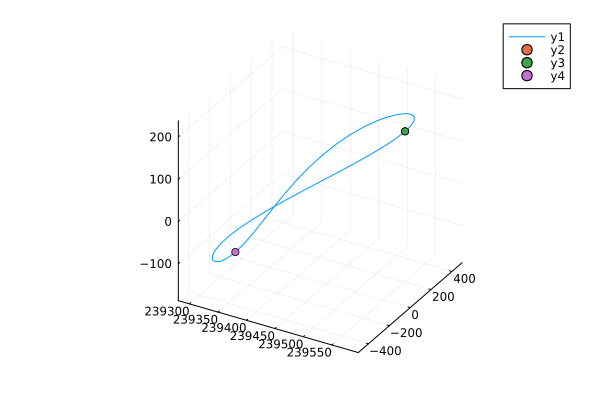

In [484]:
plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])

scatter!([reference_trajectory[1,end]], [reference_trajectory[2,end]], [reference_trajectory[3,end]])

scatter!([reference_trajectory[1,21]], [reference_trajectory[2,21]], [reference_trajectory[3,21]])


#plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

In [485]:
x_initial_ref

6-element Vector{Float64}:
 1.0e-6
 0.0
 0.0
 0.0
 1.0e-6
 0.0

In [486]:
#reference_traj_1 = [reference_trajectory reference_trajectory]

In [487]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.238529
 0.0
 0.0
 0.0
 6.84659085618205
 0.0

In [488]:
N_h

81

In [489]:
#just test to see if it solves

#all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
#all_Bd_1 = cat(all_Bd, all_Bd, dims=3)
bias_0 = zeros(6, N_h-1)

#there was nothing in place for all_Ad_1, maybe a bug? 
display("updating prob")
cons, X, U = update_prob(x_initial_ref_scaled, all_Ad_1, all_Bd_1, V_2orbits, unstable_directions_2, bias_0, reference_trajectory2)
display("solving")
display(X)
Xm, Um = solve_opt(cons, X, U, N_h)

"updating prob"

"solving"

Variable
size: (6, 81)
sign: real
vexity: affine
id: 125…316

([0.238529 0.21697152684095267 … -0.23715117608504152 -0.28146085149690137; 0.0 0.01657719993163386 … 0.0728288091651397 0.09283180628635025; … ; 6.84659085618205 5.86550912869237 … 6.459369401271431 8.524242148456578; 0.0 -1.500684233983429 … -1.9990410018738292 -2.487219274080662], [-7646.594307792072 -4.795857862890356e-6 … 1.033193575952112e-9 9.117345511602731e-10; -775.045415591155 -8.704651671641182e-5 … -2.078241382001786e-10 -3.480772870776505e-10; -797.1466135427731 -1.132641522793246e-5 … 1.1873005002154534e-10 1.3030623431692034e-10])

In [490]:
norm(x_initial_ref_scaled[1:3]) 

0.238529

In [491]:
Um

3×80 Matrix{Float64}:
 -7646.59   -4.79586e-6     -6.13483e-7  …   1.03319e-9    9.11735e-10
  -775.045  -8.70465e-5  -4336.7            -2.07824e-10  -3.48077e-10
  -797.147  -1.13264e-5     -2.46669e-6      1.1873e-10    1.30306e-10

In [493]:
#check the constraint

#this is because the constraint is from 2:Nh
constraint_satisfied = zeros(N_h)

for i=1:N_h
    constraint_satisfied[i] = dot(Xm[:,i], unstable_directions_2[:,i])
end

#constraint is not being satisfied... has to do with the cost function. whenever I have a
#tracking cost with a weight of 1e-2 and a control cost with scale 1, it doesn't work. However, 
#when I remove the cost on the controls and make the weight less on the tracking (1e-5) it works (up to the last point)

#with just a tracking cost with a weight of 1e-2 it doesn't satisfy the constraint fully

In [494]:
constraint_satisfied[1]

2.9086206060418522

In [495]:
constraint_satisfied[15]

0.5689590228108459

In [496]:
Xm[:,18]/norm(Xm[:,18])

6-element Vector{Float64}:
  0.014145617686158938
  0.01108198214052263
  0.010433291149728146
 -0.8076868377103276
 -0.5759323188185612
  0.12454787809378777

In [497]:
unstable_directions[:,18]

6-element Vector{Float64}:
 -0.008960696787909209
  0.009564799953762781
 -0.00010338738082673086
 -0.6961059718901272
  0.7069615032521865
  0.12437893167365383

In [498]:
constraint_satisfied[60:70]

11-element Vector{Float64}:
 0.3951729327435461
 0.5157240022382309
 0.6575083747877667
 0.8221475350657962
 1.0122104096504734
 1.227508200212342
 1.471878683717547
 1.7521082360618834
 2.0742660988426285
 2.4470302565281927
 2.8829926547124654

In [499]:
constraint_satisfied

81-element Vector{Float64}:
  2.9086206060418522
 17.024191292947098
 14.3644765924912
  6.387705252266482
  5.224154576871111
  4.260841666246094
  3.467827239372623
  2.816549578248415
  2.2823762718267546
  1.843313259148037
  ⋮
  4.733672858238857
  5.609293782344045
  6.667373439412437
  7.951293697603546
  9.516547087268998
 11.424183242951983
 13.746175913928328
 16.56868734832042
 19.99602738107849

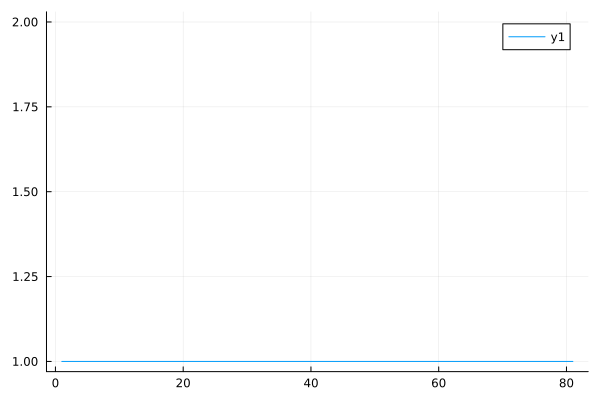

In [500]:
constraint_bool = constraint_satisfied .> 0

plot(constraint_bool)

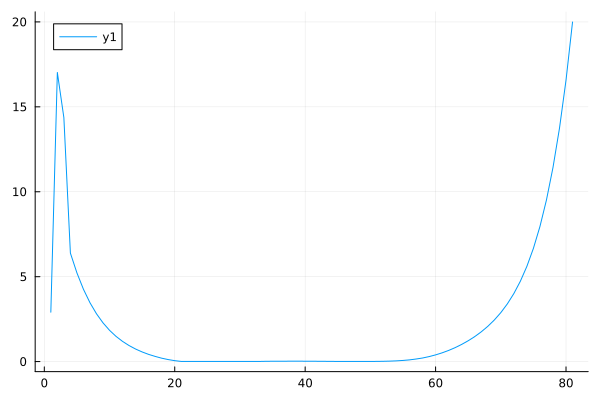

In [501]:
plot(constraint_satisfied)

In [502]:
constraint_satisfied

81-element Vector{Float64}:
  2.9086206060418522
 17.024191292947098
 14.3644765924912
  6.387705252266482
  5.224154576871111
  4.260841666246094
  3.467827239372623
  2.816549578248415
  2.2823762718267546
  1.843313259148037
  ⋮
  4.733672858238857
  5.609293782344045
  6.667373439412437
  7.951293697603546
  9.516547087268998
 11.424183242951983
 13.746175913928328
 16.56868734832042
 19.99602738107849

In [503]:
constraint_bool[44]

true

In [504]:
Xm 

6×81 Matrix{Float64}:
 0.238529    0.216972      0.17902     …   -0.237151    -0.281461
 0.0         0.0165772     0.0349573        0.0728288    0.0928318
 0.0        -0.00200333   -0.00527251      -0.0328125   -0.0388196
 0.0       -16.1318      -12.1808         -15.1286     -17.9207
 6.84659     5.86551       7.6835           6.45937      8.52424
 0.0        -1.50068      -0.95068     …   -1.99904     -2.48722

In [505]:
residual = zeros(6, N_h-1)

6×80 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [506]:
reference_trajectory[:,1]

6-element Vector{Float64}:
 239587.62743544072
      2.885776193752321e-15
    226.1684428275936
     -5.94859626923431e-9
 -26419.73544475346
     -6.138613580085994e-9

In [507]:
reference_trajectory[:,end]

6-element Vector{Float64}:
 239587.62743536415
      2.501107314628918e-8
    226.16844282250426
     -4.8229915553111815e-6
 -26419.735442449262
     -8.123025534991029e-7

In [508]:
input = [Xm[:,1] + reference_trajectory[:,1]; Um[:,1]]

9-element Vector{Float64}:
 239587.86596444072
      2.885776193752321e-15
    226.1684428275936
     -5.94859626923431e-9
 -26412.88885389728
     -6.138613580085994e-9
  -7646.594307792072
   -775.045415591155
   -797.1466135427731

In [509]:
#reference_trajectory2 = [reference_trajectory reference_trajectory]

In [510]:
#find the residual

for k = 1:N_h-1

    input = [Xm[:,k] + reference_trajectory2[:,k]; Um[:,k]]

    xnext_sol = dynamics_wcontrol_integrate(input, Δt)

    residual[:,k] = reference_trajectory2[:,k+1] + Xm[:,k+1] - xnext_sol.u[end][1:6]

end

In [511]:
residual

6×80 Matrix{Float64}:
  7.13713e-7    8.8237e-7     4.77681e-7   …  8.59785e-7   1.24599e-6
 -9.56265e-7   -1.95173e-7   -9.96859e-8      2.55898e-7   2.77851e-7
  3.99805e-7    2.59711e-7    3.88967e-7      1.81707e-7   2.84396e-7
  0.000532672   0.000390344   0.000225582     0.000488303  0.000754492
 -8.96471e-5   -0.000198307  -9.92343e-5      0.000229574  0.00024334
  0.000264113   0.000189746   0.0001254    …  0.000142737  0.000222081

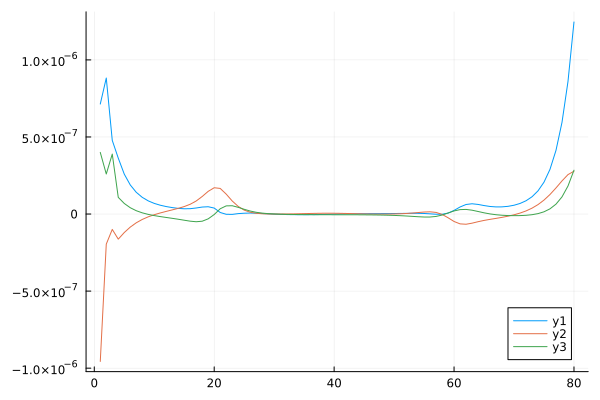

In [512]:
plot(residual[1,:])
plot!(residual[2,:])
plot!(residual[3,:])

In [513]:
#for one period 40 controls
xtraj_test = integrate_oneperiod(Xm[:,1] + reference_trajectory[:,1], Um[:,1:40])

6×41 Matrix{Float64}:
      2.39588e5         2.39585e5  …       2.39585e5       2.39588e5
      2.88578e-15     -70.694             70.7122          0.00248441
    226.168           224.138            224.121         226.151
     -5.9486e-9     -1845.18            1828.41           -0.749133
 -26412.9          -26113.9           -26119.4        -26419.4
     -6.13861e-9    -1509.54       …    1508.36            0.408875

In [514]:
# Xm[:,1]

In [515]:
delta_test = xtraj_test - reference_trajectory

6×41 Matrix{Float64}:
 0.238529    0.216971      0.179017    …  -0.00695505  -0.00882206
 0.0         0.0165782     0.0349588       0.0015845    0.00248439
 0.0        -0.00200373   -0.00527388     -0.0185164   -0.0175385
 0.0       -16.1324      -12.1818         -0.633858    -0.749128
 6.84659     5.8656        7.68387         0.290768     0.384298
 0.0        -1.50095      -0.951133    …   0.320307     0.408876

In [516]:
# dot(delta_test[:,1], unstable_directions[:,1])

In [517]:
# delta_test - Xm[:,1:41]

In [518]:
# xtraj_test[:,1] - reference_trajectory[:,1]

In [519]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.238529
 0.0
 0.0
 0.0
 6.84659085618205
 0.0

In [520]:
# delta_test[:,1]

In [521]:
Xm[:,1]

6-element Vector{Float64}:
 0.238529
 0.0
 0.0
 0.0
 6.84659085618205
 0.0

In [522]:
constraint_satisfied_ndynamics = zeros(41)

for i=1:41
    constraint_satisfied_ndynamics[i] = dot(delta_test[:,i], unstable_directions[:,i])
end

In [523]:
# delta_test[:,21]

In [524]:
constraint_satisfied_ndynamics

41-element Vector{Float64}:
  2.9086206060415383
 17.024738242391006
 14.365521023411992
  6.389083504135348
  5.2258455084187245
  4.26282257663869
  3.470103314357032
  2.8191489155162355
  2.2853477036247556
  1.8467267397891411
  ⋮
  0.18767013915082773
  0.22794550984519474
  0.27132641517900097
  0.3201943686759065
  0.38041410043218093
  0.4534885600944268
  0.540595165780239
  0.6444071701571186
  0.7713311858473735

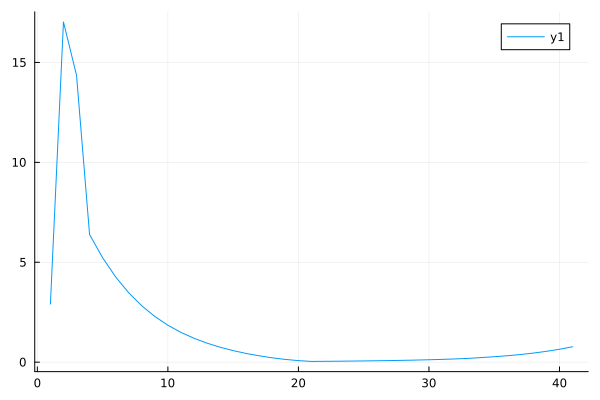

In [525]:
plot(constraint_satisfied_ndynamics)

In [526]:
constraint_satisfied

81-element Vector{Float64}:
  2.9086206060418522
 17.024191292947098
 14.3644765924912
  6.387705252266482
  5.224154576871111
  4.260841666246094
  3.467827239372623
  2.816549578248415
  2.2823762718267546
  1.843313259148037
  ⋮
  4.733672858238857
  5.609293782344045
  6.667373439412437
  7.951293697603546
  9.516547087268998
 11.424183242951983
 13.746175913928328
 16.56868734832042
 19.99602738107849

In [527]:
constraint_satisfied_ndynamics

41-element Vector{Float64}:
  2.9086206060415383
 17.024738242391006
 14.365521023411992
  6.389083504135348
  5.2258455084187245
  4.26282257663869
  3.470103314357032
  2.8191489155162355
  2.2853477036247556
  1.8467267397891411
  ⋮
  0.18767013915082773
  0.22794550984519474
  0.27132641517900097
  0.3201943686759065
  0.38041410043218093
  0.4534885600944268
  0.540595165780239
  0.6444071701571186
  0.7713311858473735

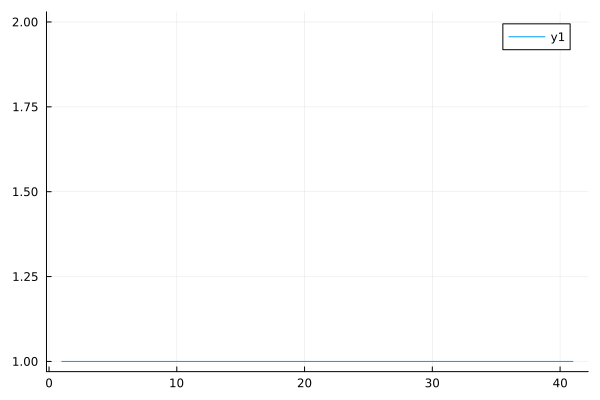

In [528]:
plot(constraint_satisfied_ndynamics .>0)

In [529]:
constraint_satisfied_ndynamics

41-element Vector{Float64}:
  2.9086206060415383
 17.024738242391006
 14.365521023411992
  6.389083504135348
  5.2258455084187245
  4.26282257663869
  3.470103314357032
  2.8191489155162355
  2.2853477036247556
  1.8467267397891411
  ⋮
  0.18767013915082773
  0.22794550984519474
  0.27132641517900097
  0.3201943686759065
  0.38041410043218093
  0.4534885600944268
  0.540595165780239
  0.6444071701571186
  0.7713311858473735

In [530]:
final = Xm + [reference_trajectory reference_trajectory[:,2:end]]

6×81 Matrix{Float64}:
      2.39588e5         2.39585e5  …       2.39585e5       2.39587e5
      2.88578e-15     -70.694             70.7834          0.0928318
    226.168           224.138            224.107         226.13
     -5.9486e-9     -1845.18            1813.92          -17.9207
 -26412.9          -26113.9           -26113.3        -26411.2
     -6.13861e-9    -1509.54       …    1506.04           -2.48722

In [531]:
residual

6×80 Matrix{Float64}:
  7.13713e-7    8.8237e-7     4.77681e-7   …  8.59785e-7   1.24599e-6
 -9.56265e-7   -1.95173e-7   -9.96859e-8      2.55898e-7   2.77851e-7
  3.99805e-7    2.59711e-7    3.88967e-7      1.81707e-7   2.84396e-7
  0.000532672   0.000390344   0.000225582     0.000488303  0.000754492
 -8.96471e-5   -0.000198307  -9.92343e-5      0.000229574  0.00024334
  0.000264113   0.000189746   0.0001254    …  0.000142737  0.000222081

In [532]:
#test out the integration function
#xtraj_test = integrate_oneperiod(final[:,1], Um[:,1:39])

In [533]:
#plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

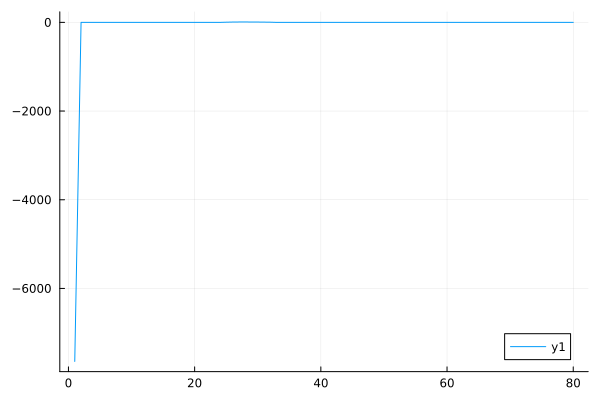

In [534]:
plot(Um[1,:])

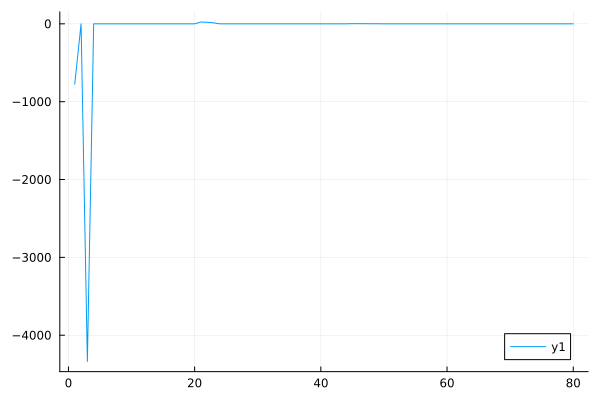

In [535]:
plot(Um[2,:])

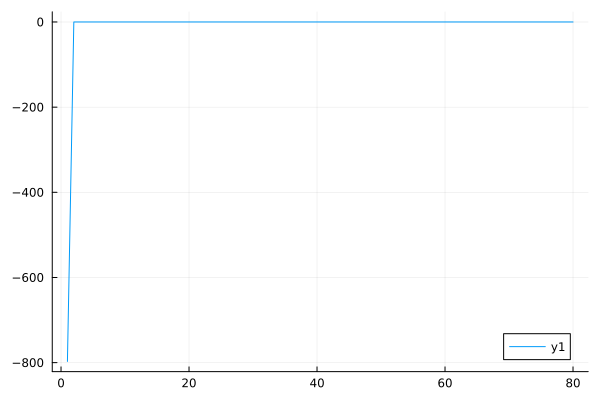

In [536]:
plot(Um[3,:])

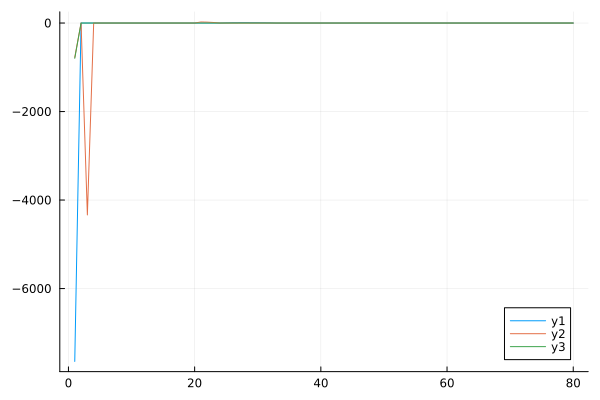

In [537]:
plot(Um[1,:])
plot!(Um[2,:])
plot!(Um[3,:])

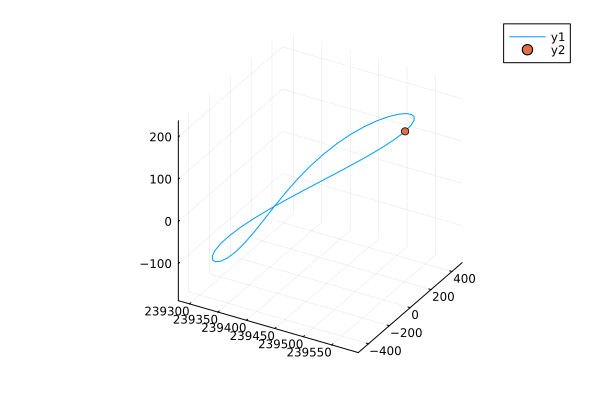

In [538]:
#check out the 1 period solve

#the x trajectory is generated using the linear dynamics
plot(final[1,1:41], final[2,1:41], final[3,1:41])
scatter!([final[1,1]], [final[2,1]], [final[3,1]])

In [539]:
#plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

In [540]:
#xtraj_test - reference_trajectory

In [541]:
#unstable_directions[:,2]

In [542]:
#norm(xtraj_test[:,41] - xtraj_test[:,1])

In [543]:
residual

6×80 Matrix{Float64}:
  7.13713e-7    8.8237e-7     4.77681e-7   …  8.59785e-7   1.24599e-6
 -9.56265e-7   -1.95173e-7   -9.96859e-8      2.55898e-7   2.77851e-7
  3.99805e-7    2.59711e-7    3.88967e-7      1.81707e-7   2.84396e-7
  0.000532672   0.000390344   0.000225582     0.000488303  0.000754492
 -8.96471e-5   -0.000198307  -9.92343e-5      0.000229574  0.00024334
  0.000264113   0.000189746   0.0001254    …  0.000142737  0.000222081

In [544]:
#solve the problem again and pass in the residual as the bias in the dynamics constraint
display("updating prob")
cons, X, U = update_prob(x_initial_ref_scaled, all_Ad_1, all_Bd_1, V_2orbits, unstable_directions_2, residual, reference_trajectory2)
display("solving")
display(X)
Xm2, Um2 = solve_opt(cons, X, U, N_h)

"updating prob"

"solving"

Variable
size: (6, 81)
sign: real
vexity: affine
id: 490…174

([0.238529 0.2169707040259684 … -0.23717037113197553 -0.2814788466456582; 0.0 0.01657514760716046 … 0.07284727550455172 0.0928540651265628; … ; 6.84659085618205 5.864634649012537 … 6.460726815608336 8.525746765757; 0.0 -1.5010922694768052 … -1.9990579678817681 -2.487047661113391], [-7647.002638642597 -4.710752579817563e-6 … 1.029375844263005e-9 9.005327056956058e-10; -775.371131870503 -8.564300639456956e-5 … -2.0533051054914298e-10 -3.454180498129029e-10; -797.3969839811609 -1.1141003615293085e-5 … 1.3764286881516546e-10 1.286461020363539e-10])

In [545]:
half_rev_control = Um2[1:3, 1:21]/acceleration_scale

3×21 Matrix{Float64}:
 -3.8912e-5   -2.39708e-14  -3.06809e-15  …  -6.68616e-16  -6.59712e-16
 -3.9455e-6   -4.35797e-13  -2.20648e-5       2.37951e-15   1.19955e-7
 -4.05758e-6  -5.66913e-14  -1.23523e-14      1.03163e-15   1.54703e-15

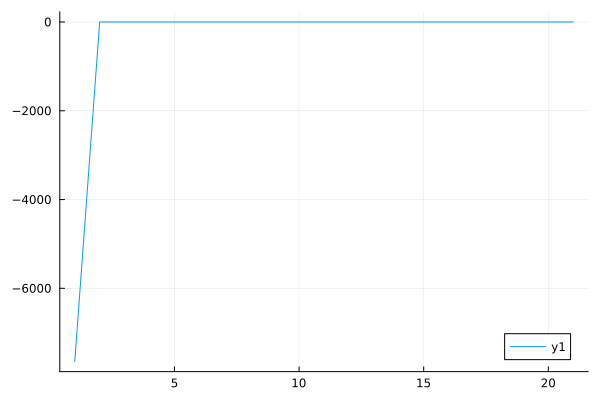

In [547]:
plot(Um2[1,1:21])

In [548]:
Um2[:,1]

3-element Vector{Float64}:
 -7647.002638642597
  -775.371131870503
  -797.3969839811609

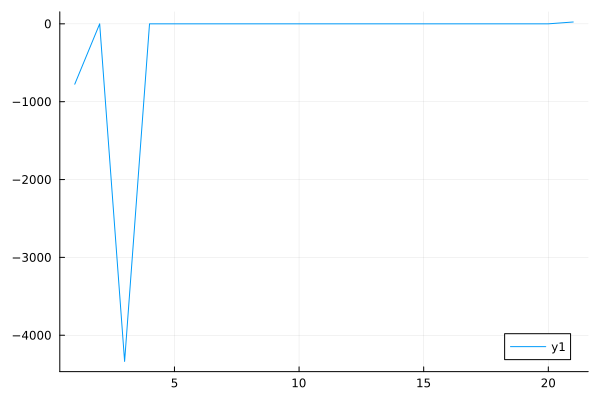

In [549]:
plot(Um2[2,1:21])

In [550]:
#plot(Um2[2,30:40])

In [551]:
#Um2[2, 32]

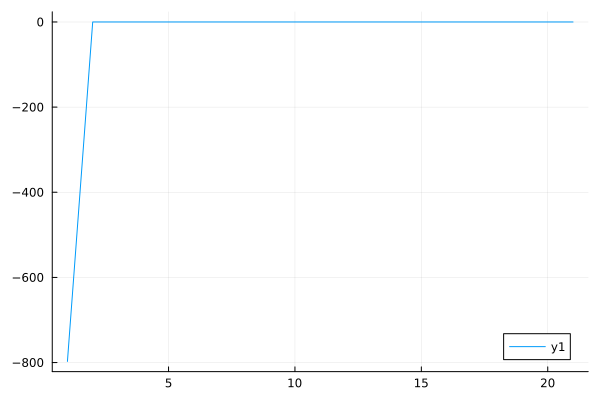

In [552]:
plot(Um2[3,1:21])

In [553]:
#for one period 40 controls
# xtraj_test2 = integrate_oneperiod(Xm2[:,1] + reference_trajectory[:,1], Um2[:,1:40])

In [554]:
# plot(xtraj_test2[1,:], xtraj_test2[2,:], xtraj_test2[3,:])
#scatter!([xtraj_test2[1,1]], [xtraj_test2[2,1]], [xtraj_test2[3,1]])

In [555]:
# xtraj_test2[:,1]

In [556]:
# xtraj_test2[:,41]

In [557]:
#similar to the first solve. No point in doing a second correction
#norm(xtraj_test2[:,1] - xtraj_test2[:,41])

In [558]:
#norm(xtraj_test2[:,41] - reference_trajectory[:,41])

In [559]:
#reference_trajectory[:,41]

In [560]:
#find if the updated solution satisfies the constraints
#delta_test2 = xtraj_test2 - reference_trajectory

In [561]:
#end_state = xtraj_test2[:,21]

#end_state_sim = just_dynamics_integrate(end_state, 2.75*sol_t_final[end])


#end_state_traj = get_state(end_state_sim)

In [562]:
#plot(end_state_traj[1,:],end_state_traj[2,:])
#scatter!([end_state_traj[1,1]],[end_state_traj[2,1]])

In [563]:
# constraint_satisfied_ndynamics2 = zeros(41)

# for i=1:41
#     constraint_satisfied_ndynamics2[i] = dot(delta_test2[:,i], unstable_directions[:,i])
# end

In [564]:
# plot(constraint_satisfied_ndynamics2 .>0)

In [565]:
#fixed the reference trajectory and added some slack on the halfspace constraint and it seems like I don't need to use the second order correction
#anymore

In [566]:
#this initial condition is working
#x_initial_ref = [1e-4, 0, 0, 0, 1e-4, 0]

#x_initial_ref = [1e-6, 0, 0, 0, 1e-6, 0]


#x_initial_ref = [1e-3, 0, 0, 0, 1e-3, 0]

In [567]:
# xposedeviation = x_initial_ref[1] * L*1e3 #in meters

# vyposedeviation = x_initial_ref[5]*V_*1e3 #in m/s

# display(xposedeviation)
# display(vyposedeviation)

In [568]:
#this is one set of jacobians. if starting from beginning 

#all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
#all_Bd_1 = cat(all_Bd, all_Bd, dims=3)

In [569]:
all_Ad[:,:,21:end]

6×6×21 Array{Float64, 3}:
[:, :, 1] =
  1.0388         0.000783757   -0.0105826    …   0.000209714  -9.4323e-6
 -0.000352537    0.98403        0.000171031      0.0026617    -1.33541e-7
 -0.0105881     -0.000369314    0.983451        -8.59422e-7    0.00267174
 28.9603         0.860838      -7.84476          0.15794      -0.0104437
 -0.404248     -11.7881         0.192683         0.972482     -0.000188587
 -7.85198       -0.405432     -12.26         …  -0.00125416    0.983483

[:, :, 2] =
  1.03766       0.00536305   -0.00989336   …   0.000213654  -8.6761e-6
  0.00423182    0.984991     -0.000853585      0.00266297   -1.01534e-6
 -0.0098435    -0.00136167    0.983609        -1.68035e-6    0.00267191
 28.0112        4.20497      -7.25167          0.16217      -0.00949086
  2.94485     -11.0067       -0.549612         0.974074     -0.00112456
 -7.19701      -1.10888     -12.1213       …  -0.0020912     0.983705

[:, :, 3] =
  1.03523      0.00900594   -0.00850522  …   0.000216617  -7.34292

In [570]:
all_Ad_half = cat(all_Ad[:,:,21:end], all_Ad[:,:,2:21], dims=3)
all_Bd_half = cat(all_Bd[:,:,21:end], all_Bd[:,:,2:21], dims=3)

6×3×41 Array{Float64, 3}:
[:, :, 1] =
  3.62493e-6    1.86991e-7   -6.2941e-9
 -1.84078e-7    3.5922e-6    -3.32981e-10
 -6.2941e-9    -3.32981e-10   3.59893e-6
  0.00271006    0.000210717  -9.25814e-6
 -0.000204372   0.00266203   -3.63906e-7
 -9.20222e-6   -1.07637e-6    0.00267176

[:, :, 2] =
  3.62396e-6    1.89632e-7   -5.76703e-9
 -1.81438e-7    3.59305e-6   -8.99467e-10
 -5.76703e-9   -8.99467e-10   3.59905e-6
  0.00270834    0.00021441   -8.34475e-6
 -0.000200661   0.00266353   -1.16153e-6
 -8.22965e-6   -1.80105e-6    0.00267198

[:, :, 3] =
  3.6223e-6     1.91624e-7   -4.86421e-9
 -1.79446e-7    3.59448e-6   -1.22962e-9
 -4.86421e-9   -1.22962e-9    3.59928e-6
  0.00270574    0.000217063  -6.93566e-6
 -0.000197978   0.00266573   -1.60441e-6
 -6.79041e-6   -2.1338e-6     0.00267237

;;; … 

[:, :, 39] =
  3.62397e-6   1.81452e-7   -5.77011e-9
 -1.89617e-7   3.59305e-6    8.96714e-10
 -5.77011e-9   8.96714e-10   3.59905e-6
  0.00270935   0.000202413  -8.79598e-6
 -0.000212669 

In [571]:
all_Ad_2 = cat(all_Ad_half, all_Ad_half[:,:,2:end], dims = 3)
all_Bd_2 = cat(all_Bd_half, all_Bd_half[:,:,2:end], dims=3)

6×3×81 Array{Float64, 3}:
[:, :, 1] =
  3.62493e-6    1.86991e-7   -6.2941e-9
 -1.84078e-7    3.5922e-6    -3.32981e-10
 -6.2941e-9    -3.32981e-10   3.59893e-6
  0.00271006    0.000210717  -9.25814e-6
 -0.000204372   0.00266203   -3.63906e-7
 -9.20222e-6   -1.07637e-6    0.00267176

[:, :, 2] =
  3.62396e-6    1.89632e-7   -5.76703e-9
 -1.81438e-7    3.59305e-6   -8.99467e-10
 -5.76703e-9   -8.99467e-10   3.59905e-6
  0.00270834    0.00021441   -8.34475e-6
 -0.000200661   0.00266353   -1.16153e-6
 -8.22965e-6   -1.80105e-6    0.00267198

[:, :, 3] =
  3.6223e-6     1.91624e-7   -4.86421e-9
 -1.79446e-7    3.59448e-6   -1.22962e-9
 -4.86421e-9   -1.22962e-9    3.59928e-6
  0.00270574    0.000217063  -6.93566e-6
 -0.000197978   0.00266573   -1.60441e-6
 -6.79041e-6   -2.1338e-6     0.00267237

;;; … 

[:, :, 79] =
  3.62397e-6   1.81452e-7   -5.77011e-9
 -1.89617e-7   3.59305e-6    8.96714e-10
 -5.77011e-9   8.96714e-10   3.59905e-6
  0.00270935   0.000202413  -8.79598e-6
 -0.000212669 

In [572]:
#another set of jacobians if starting from half

#all_Ad_half = cat(all_Ad[:,:,21:end], all_Ad[:,:,1:20], dims=3)
#all_Bd_half = cat(all_Bd[:,:,21:end], all_Bd[:,:,1:20], dims=3)

#all_Ad_2 = cat(all_Ad_half, all_Ad_half, dims=3)
#all_Bd_2 = cat(all_Bd_half, all_Bd_half, dims=3)

#All Ad1 is if you start from the beginning (2 orbits worth of jacobians) and all_Ad_2 is if you start from the half (2 orbits worth of jacobians).
#need to also have two sets of cost to go and unstable direction matrices that we pass in in the update_prob function 

In [573]:
#unstable directions is good. Need to fix V_2orbits
unstable_directions_half = cat(unstable_directions[:,21:end], unstable_directions[:,2:21], dims=2)

#P is for the 16 orbits. Need the one for just 1 orbit
V_half = cat(V[:,:,21:end], V[:,:,2:21], dims=3)


#unstable directions if you start from the beginning
unstable_directions_2_1 = unstable_directions_2
#this is the unstable direction if you start at the half
unstable_directions_2_2 = cat(unstable_directions_half, unstable_directions_half[:,2:end], dims=2)


#cost to go if you start from the beginning
V_2orbits_1 = V_2orbits

#cost to go in you start at the half
V_2orbits_2 = cat(V_half, V_half[:,:,2:end], dims=3)

6×6×81 Array{Float64, 3}:
[:, :, 1] =
      5.8874e5  -12856.4     -96560.9     4179.69     3901.53     -458.688
 -12856.4          281.216     2108.6      -91.2669    -85.2025     10.0089
 -96560.9         2108.6      15838.3     -685.529    -639.902      75.2127
   4179.69         -91.2669    -685.529     29.6735     27.698      -3.25632
   3901.53         -85.2025    -639.902     27.698      25.8559     -3.03945
   -458.688         10.0089      75.2127    -3.25632    -3.03945     0.358485

[:, :, 2] =
 568370.0   27825.6     -84383.2     3978.71     3973.44     -282.47
  27825.6    1362.72     -4131.2      194.786     194.532     -13.8335
 -84383.2   -4131.2      12528.7     -590.705    -589.916      41.9327
   3978.71    194.786     -590.705     27.8522     27.8145     -1.97727
   3973.44    194.532     -589.916     27.8145     27.7788     -1.97452
   -282.47    -13.8335      41.9327    -1.97727    -1.97452     0.141571

[:, :, 3] =
 534248.0    58156.7    -67604.2     3759.71     

In [574]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.238529
 0.0
 0.0
 0.0
 6.84659085618205
 0.0

In [575]:
unstable_directions_2[:,1]

6-element Vector{Float64}:
 -0.014154755627771133
  0.0045804331963484905
 -0.0009493005547567748
 -0.8925696587902248
  0.42532071609297856
 -0.1489948120659455

In [576]:
#pseudo code

orbit_count = 0
orbits = true

#number of orbits you want to plan go for
orbit_num = 100

halforbit_num = orbit_num*2 

#this is for each orbit plan

optimal_Δx = zeros(nx, N_period)
optimal_u = zeros(nu, N_period-1)

#data for all the orbits
all_optimal_Δx = zeros(nx, 21, halforbit_num)
all_optimal_x = zeros(nx, 21, halforbit_num)
all_optimal_u = zeros(nu, 20, halforbit_num)

solution_xm = zeros(6, 81, halforbit_num)
solution_um = zeros(6, 80, halforbit_num)

#optimal_Δx[:,1] = x_initial_ref


#while orbits
    
#    orbits=false
    
#for i=1:N_period-1
 
#i is now the number of times it orbits
for i=1:halforbit_num

        
    #Ad_k = cat(all_Ad_3p[:,:,i:end],all_Ad_3p[:,:,1:(i-1)], dims=3)
    #Bd_k = cat(all_Bd_3p[:,:,i:end],all_Bd_3p[:,:,1:(i-1)], dims=3)
    
    #Ad_k = cat(all_Ad[:,:,i:end],all_Ad[:,:,1:(i-1)], dims=3)
    #Bd_k = cat(all_Bd[:,:,i:end],all_Bd[:,:,1:(i-1)], dims=3)
    
    #Ad_k = all_Ad_3p[:,:,1:N_h]
    #Bd_k = all_Bd_3p[:,:,1:N_h]
      
    #horizon is two orbits ahead
    #all_Ad_k = cat(Ad_k, Ad_k, dims=3)
    #all_Bd_k = cat(Bd_k, Bd_k, dims=3)
        
    #cons, X, U = update_prob(optimal_Δx[:,i], all_Ad_k, all_Bd_k)
    
    #if you start from the beginning use the appropriate set of jacobians
    if i%2 != 0
        #println("using jacobian 1")
        all_Ad_k = all_Ad_1
        all_Bd_k = all_Bd_1
        unstable_directions_k = unstable_directions_2_1
        P_k = V_2orbits_1 
        reference_traj_k = reference_trajectory2       
    else
        #println("using jacobian 2")
        all_Ad_k = all_Ad_2
        all_Bd_k = all_Bd_2
        unstable_directions_k = unstable_directions_2_2
        P_k = V_2orbits_2
        reference_traj_k = reference_trajectory2_2
    end
    
    #the zeros is the bias 
    cons, X, U = update_prob(x_initial_ref_scaled, all_Ad_k, all_Bd_k, P_k, unstable_directions_k, zeros(6, N_h-1), reference_traj_k)
        
    Xm, Um = solve_opt(cons, X, U,N_h)

    solution_xm = Xm
    solution_um = Um
    
    #get the optimal controls for half a period (20 for this example)
        
    optimal_u = Um[:,1:20]
        
    #size N_period
        
    orbit_count += 1
    
    #rollout on the nonlinear dynamics
    if i%2 != 0
        
        #print("from beginning")
        
        xtraj_halfperiod = integrate_halfperiod(reference_trajectory[:,1] + Xm[:,1], optimal_u)

        #this is the deviation from the reference
        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,1:21]
        
        #integrate the initial condition by all the optimal controls from the solver        
    else
        
        #print("this is reference trajectory at half: ", reference_trajectory[:,21])
        #println("from half")
        xtraj_halfperiod = integrate_halfperiod(reference_trajectory[:,21] + Xm[:,1], optimal_u)

        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,21:41] 
        #integrate the initial condition by all the optimal controls from the solver
        
    end
    
    all_optimal_x[:,:,orbit_count] = xtraj_halfperiod
    
    all_optimal_u[:,:,orbit_count] = optimal_u
    
    println("Half Revolution solved: ", i)
    
    #update the intiial condition for the next rev (has to be a delta)
    x_initial_ref_scaled = all_optimal_Δx[:,end, orbit_count]

    #println("this is the initial condition for the next rev: ", x_initial_ref)
    
end  

Half Revolution solved: 1
Half Revolution solved: 2
Half Revolution solved: 3
Half Revolution solved: 4
Half Revolution solved: 5
Half Revolution solved: 6
Half Revolution solved: 7
Half Revolution solved: 8
Half Revolution solved: 9
Half Revolution solved: 10
Half Revolution solved: 11
Half Revolution solved: 12
Half Revolution solved: 13
Half Revolution solved: 14
Half Revolution solved: 15
Half Revolution solved: 16
Half Revolution solved: 17
Half Revolution solved: 18
Half Revolution solved: 19
Half Revolution solved: 20
Half Revolution solved: 21
Half Revolution solved: 22
Half Revolution solved: 23
Half Revolution solved: 24
Half Revolution solved: 25
Half Revolution solved: 26
Half Revolution solved: 27
Half Revolution solved: 28
Half Revolution solved: 29
Half Revolution solved: 30
Half Revolution solved: 31
Half Revolution solved: 32
Half Revolution solved: 33
Half Revolution solved: 34
Half Revolution solved: 35
Half Revolution solved: 36
Half Revolution solved: 37
Half Revol

In [577]:
#the current problem is that the linear problem does satisfy the dynamics, however, the nonlinear rollout breaks those dynamics. need second order
# correction for the MPC problem. FIXED 

In [578]:
all_optimal_Δx

6×21×200 Array{Float64, 3}:
[:, :, 1] =
 0.238529    0.216971      0.179017    …   0.0119624    0.0100456
 0.0         0.0165782     0.0349588       0.00929257   0.00721406
 0.0        -0.00200373   -0.00527388      0.0118809    0.0107939
 0.0       -16.1324      -12.1818         -0.751208    -0.66503
 6.84659     5.8656        7.68387        -0.769386    -0.77738
 0.0        -1.50095      -0.951133    …  -0.301424    -0.522094

[:, :, 2] =
  0.0100456    0.00842978   0.00713002  …   0.00231592   0.00211082
  0.00721406   0.00541062   0.00397401     -0.00194629  -0.00202249
  0.0107939    0.00912283   0.00700303     -0.0148621   -0.0140638
 -0.66503     -0.532397    -0.4368         -0.0654972   -0.0776199
 -0.77738     -0.559563    -0.505774       -0.0360057   -0.0189025
 -0.522094    -0.719896    -0.851443    …   0.251144     0.345407

[:, :, 3] =
  0.00211082   0.00189081   0.0016569   …   0.00150669    0.00160274
 -0.00202249  -0.00204404  -0.00200422      0.000391287   0.000304848


In [579]:
dot(all_optimal_Δx[:,end,1], unstable_directions_2[:,21])

0.03549163225729979

In [580]:
dot(all_optimal_Δx[:,end,2], unstable_directions_2[:,1])

0.009751875228173463

In [581]:
#dot(acceleration_scale[:,end,2], unstable_directions_2_2[:,21])

In [582]:
solution_xm

6×81 Matrix{Float64}:
 -0.000859669  -0.000849449  -0.000802947  …   -0.151198     -0.190595
  0.000368544   0.000406582   0.000427718       0.151469      0.178495
 -0.00450057   -0.00440613   -0.00415371        0.00645727    0.0164991
 -0.00149479    0.0115204     0.0229045       -12.8697      -16.5604
  0.0177457     0.011446      0.00460369        9.72372      10.3287
  0.0023503     0.0641399     0.122421     …    3.11096       4.36719

In [583]:
unstable_directions_2_2

6×81 Matrix{Float64}:
 -0.00948995  -0.00996026  -0.0105469   …  -0.00916181   -0.00948995
  0.00885875   0.00851811   0.00812971      0.00914996    0.00885875
  0.00104137   0.00142293   0.00177742      0.000650366   0.00104137
 -0.828211    -0.868446    -0.902084       -0.783552     -0.828211
  0.515586     0.436984     0.360496        0.590017      0.515586
  0.219246     0.233824     0.236869    …   0.194315      0.219246

In [584]:
xtraj_halfperiod_test = integrate_halfperiod(reference_trajectory[:,21] + solution_xm[:,1], optimal_u)

6×21 Matrix{Float64}:
     2.39289e5        2.3929e5  …       2.39585e5       2.39588e5
     0.000368432     80.0756           70.7106          6.75348e-5
  -175.731         -172.395           224.146         226.174
    -0.0014763      541.071          1829.04            0.000544985
 29978.9          29460.0          -26119.7        -26419.7
     0.00233599    2469.92      …    1508.08            0.0033925

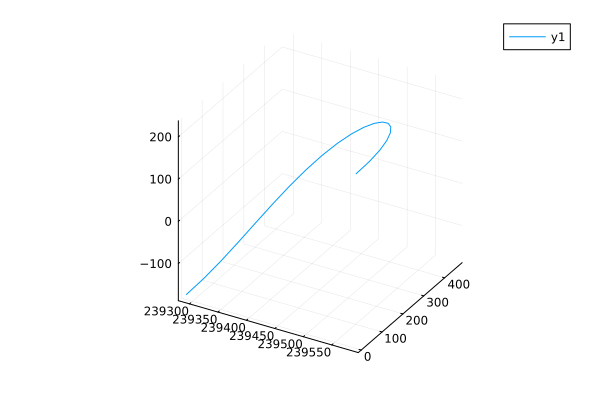

In [586]:
plot(xtraj_halfperiod_test[1,:],xtraj_halfperiod_test[2,:], xtraj_halfperiod_test[3,:])

In [587]:
test_deltas = xtraj_halfperiod_test - reference_trajectory[:,21:end]

6×21 Matrix{Float64}:
 -0.000859669  -0.000849449  -0.000802943  …  -0.000828118  -0.000848396
  0.000368544   0.000406588   0.000427728     -1.10983e-6    6.75098e-5
 -0.00450057   -0.00440613   -0.0041537        0.00574235    0.00579778
 -0.00149479    0.0115204     0.0229046       -0.00657924    0.000549808
  0.0177457     0.011446      0.00460316       0.0253243     0.026782
  0.0023503     0.0641411     0.122423     …   0.0410022     0.00339331

In [588]:
test_deltas - solution_xm[:,1:21]

6×21 Matrix{Float64}:
 0.0   7.95218e-11   3.42543e-9   4.61395e-9  …   3.0435e-8    3.79351e-8
 0.0   5.69021e-9    1.00292e-8   1.32723e-8     -4.1168e-8   -4.18847e-8
 0.0   2.59627e-9    1.27111e-8   2.71956e-8      6.97286e-8   5.54322e-8
 0.0  -2.36344e-8    2.1339e-8    2.29759e-7      2.59033e-6   3.32073e-6
 0.0  -4.02381e-8   -5.33277e-7  -1.18284e-6     -6.35958e-7  -8.58916e-7
 0.0   1.14705e-6    2.26149e-6   3.16703e-6  …  -5.22668e-6  -5.48348e-6

In [589]:
#linear problem is good
solution_xm[:, 1:21]

6×21 Matrix{Float64}:
 -0.000859669  -0.000849449  -0.000802947  …  -0.000828148  -0.000848434
  0.000368544   0.000406582   0.000427718     -1.06866e-6    6.75517e-5
 -0.00450057   -0.00440613   -0.00415371       0.00574228    0.00579773
 -0.00149479    0.0115204     0.0229045       -0.00658183    0.000546487
  0.0177457     0.011446      0.00460369       0.0253249     0.0267829
  0.0023503     0.0641399     0.122421     …   0.0410074     0.0033988

In [590]:
#linear problem is good and solves
test = zeros(21)

for k=1:21
    test[k] = dot(test_deltas[:,k], unstable_directions_2_2[:,k])

end


In [591]:
test

21-element Vector{Float64}:
 0.010909473386366384
 0.010000272337267666
 0.010000328383210424
 0.011151085859555787
 0.011419953929419614
 0.010392835493776956
 0.00999944793395682
 0.009999317528246772
 0.009999201804113251
 0.009999180915756526
 ⋮
 0.009999348841167119
 0.009999396807952159
 0.009999415535473505
 0.009999370968364884
 0.009999230433167063
 0.009998998976570354
 0.010634595667285333
 0.009998139487622723
 0.010401425448726343

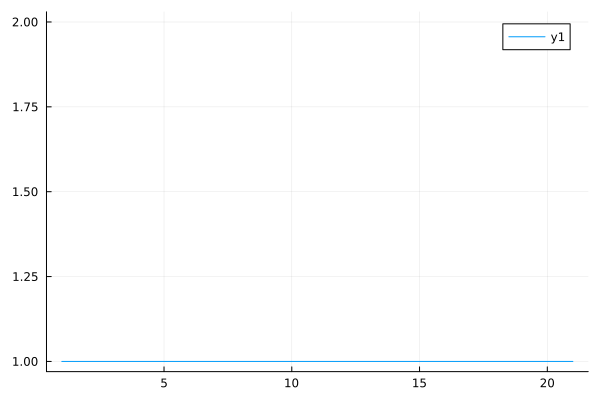

In [592]:
plot(test .>0)

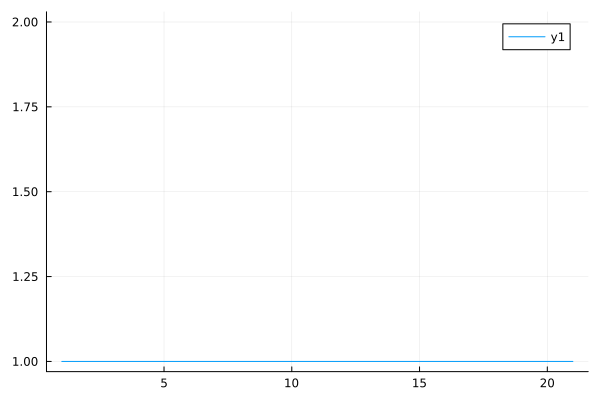

In [593]:
plot(test.>0)

In [594]:
all_xtraj[:, 1:41] 

6×41 Matrix{Float64}:
      2.39588e5         2.39585e5  …       2.39585e5       2.39588e5
      2.88578e-15     -70.694             70.7086         -0.00202247
    226.168           224.138            224.125         226.154
     -5.9486e-9     -1845.18            1828.98           -0.0776248
 -26412.9          -26113.9           -26119.8        -26419.8
     -6.13861e-9    -1509.54       …    1508.29            0.345407

In [595]:
all_xtraj[:, 42:82] 

6×41 Matrix{Float64}:
      2.39588e5        2.39585e5  …       2.39585e5       2.39588e5
     -0.00202249     -70.7126            70.7107          0.000108944
    226.154          224.127            224.131         226.159
     -0.0776199    -1829.13            1829.08            0.020473
 -26419.8         -26119.7           -26119.7        -26419.8
      0.345407     -1507.61       …    1507.73           -0.250194

In [596]:
rev1 = all_optimal_x[:,:,1]
rev2 = all_optimal_x[:,:,2]
rev3 = all_optimal_x[:,:,3]
rev4 = all_optimal_x[:,:,4]
rev5 = all_optimal_x[:,:,5]
# rev20 = all_optimal_x[:,:,20]

# rev59 = all_optimal_x[:,:,59]
# rev60 = all_optimal_x[:,:,60]
#rev25 = all_optimal_x[:,:,25]

6×21 Matrix{Float64}:
      2.39588e5         2.39585e5  …      2.3929e5      2.39289e5
      0.000108919     -70.7105          -80.0748        0.00031332
    226.159           224.13           -172.385      -175.72
      0.0204778     -1829.04           -541.01          0.0334723
 -26419.8          -26119.7           29460.0       29978.8
     -0.250193      -1508.22       …  -2469.44          0.330318

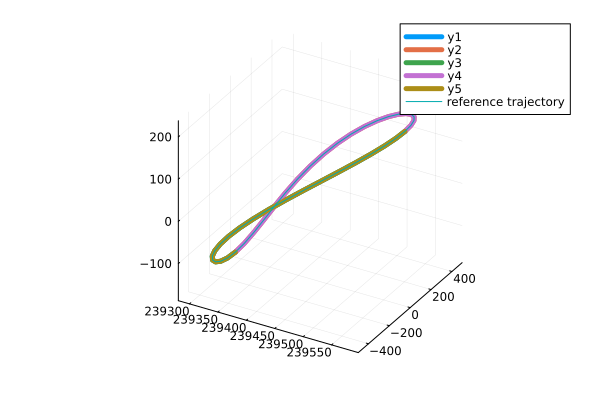

In [597]:
plot(rev1[1,:], rev1[2,:], rev1[3,:], lw=5)
#scatter!([rev1[1,1]],[rev1[2,1]],[rev1[3,1]], lw=5)
plot!(rev2[1,:], rev2[2,:], rev2[3,:], lw=5)
plot!(rev3[1,:], rev3[2,:], rev3[3,:], lw=5)
plot!(rev4[1,:], rev4[2,:], rev4[3,:], lw=5)
plot!(rev5[1,:], rev5[2,:], rev5[3,:], lw=5)
#plot!(rev59[1,:], rev59[2,:], rev59[3,:], lw=5)
#plot!(rev60[1,:], rev60[2,:], rev60[3,:], lw=5)

plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="reference trajectory")

#scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])

In [598]:
1e-3*L

238.529

In [599]:
all_optimal_x_formatted = zeros(6, N_period, orbit_num)
all_optimal_Δx_formatted = zeros(6, N_period, orbit_num)

6×41×100 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] 

In [600]:
#have orbit_num trajectories of N knot points

for i=1:orbit_num
    
    all_optimal_x_formatted[:,1:21,i] = all_optimal_x[:,:,(2*i-1)]
    
    #2:end is used to not repeat the same element twice
    all_optimal_x_formatted[:,22:end,i] = all_optimal_x[:,2:end,(2*i)]
    
    
    all_optimal_Δx_formatted[:,1:21,i] = all_optimal_Δx[:,:,(2*i-1)]
    
    all_optimal_Δx_formatted[:,22:end,i] = all_optimal_Δx[:,2:end,(2*i)]
    
end

In [601]:
all_optimal_x

6×21×200 Array{Float64, 3}:
[:, :, 1] =
      2.39588e5         2.39585e5  …      2.3929e5      2.39289e5
      2.88578e-15     -70.694           -80.0659        0.00721395
    226.168           224.138          -172.379      -175.716
     -5.9486e-9     -1845.18           -541.814        -0.665011
 -26412.9          -26113.9           29459.2       29978.1
     -6.13861e-9    -1509.54       …  -2470.15         -0.522108

[:, :, 2] =
     2.39289e5       2.3929e5  …       2.39585e5       2.39588e5
     0.00721395     80.0806           70.7086         -0.00202247
  -175.716        -172.382           224.125         226.154
    -0.665011      540.527          1828.98           -0.0776248
 29978.1         29459.5          -26119.8        -26419.8
    -0.522108     2469.14      …    1508.29            0.345407

[:, :, 3] =
      2.39588e5        2.39585e5  …      2.3929e5      2.39289e5
     -0.00202249     -70.7126          -80.0748        0.000304737
    226.154          224.127         

In [602]:
all_optimal_x_formatted

6×41×100 Array{Float64, 3}:
[:, :, 1] =
      2.39588e5         2.39585e5  …       2.39585e5       2.39588e5
      2.88578e-15     -70.694             70.7086         -0.00202247
    226.168           224.138            224.125         226.154
     -5.9486e-9     -1845.18            1828.98           -0.0776248
 -26412.9          -26113.9           -26119.8        -26419.8
     -6.13861e-9    -1509.54       …    1508.29            0.345407

[:, :, 2] =
      2.39588e5        2.39585e5  …       2.39585e5       2.39588e5
     -0.00202249     -70.7126            70.7107          0.000108944
    226.154          224.127            224.131         226.159
     -0.0776199    -1829.13            1829.08            0.020473
 -26419.8         -26119.7           -26119.7        -26419.8
      0.345407     -1507.61       …    1507.73           -0.250194

[:, :, 3] =
      2.39588e5         2.39585e5  …       2.39585e5       2.39588e5
      0.000108919     -70.7105            70.7106         -3.11

In [603]:
all_xtraj = reshape(all_optimal_x_formatted, (6, N_period*orbit_num))

all_Δxtraj = reshape(all_optimal_Δx_formatted, (6, N_period*orbit_num))
#all_xtraj = reshape(all_optimal_x, (6, 210))

6×4100 Matrix{Float64}:
 0.238529    0.216971      0.179017    …  -0.000828118  -0.000848396
 0.0         0.0165782     0.0349588      -1.10983e-6    6.75098e-5
 0.0        -0.00200373   -0.00527388      0.00574235    0.00579778
 0.0       -16.1324      -12.1818         -0.00657924    0.000549808
 6.84659     5.8656        7.68387         0.0253243     0.026782
 0.0        -1.50095      -0.951133    …   0.0410022     0.00339331

In [604]:
normz = zeros(4100)

4100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [605]:
all_Δxtraj 

6×4100 Matrix{Float64}:
 0.238529    0.216971      0.179017    …  -0.000828118  -0.000848396
 0.0         0.0165782     0.0349588      -1.10983e-6    6.75098e-5
 0.0        -0.00200373   -0.00527388      0.00574235    0.00579778
 0.0       -16.1324      -12.1818         -0.00657924    0.000549808
 6.84659     5.8656        7.68387         0.0253243     0.026782
 0.0        -1.50095      -0.951133    …   0.0410022     0.00339331

In [606]:
6.84/86400 

7.916666666666666e-5

In [607]:
for i=1:4100
    normz[i] = norm(all_Δxtraj[1:3,i])
end

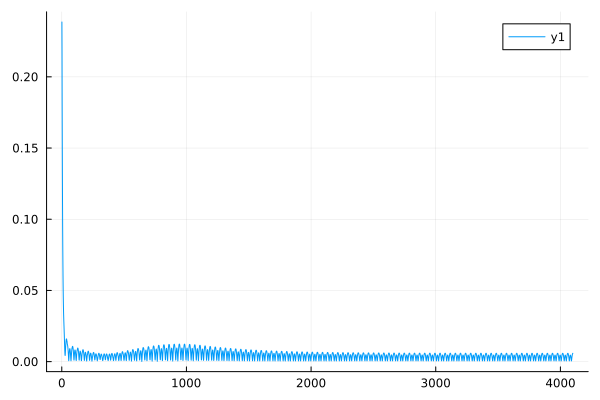

In [608]:
plot(normz)

In [609]:
all_xtraj 

6×4100 Matrix{Float64}:
      2.39588e5         2.39585e5  …       2.39585e5       2.39588e5
      2.88578e-15     -70.694             70.7106          6.75348e-5
    226.168           224.138            224.146         226.174
     -5.9486e-9     -1845.18            1829.04            0.000544985
 -26412.9          -26113.9           -26119.7        -26419.7
     -6.13861e-9    -1509.54       …    1508.08            0.0033925

In [610]:
for i=1:100
    deltaxsub = all_Δxtraj[41*(i-1)+1:41*i]

    for i=1:41
        plot(deltaxsub[1,:], deltaxsub[2,:], deltaxsub[3,:], lw=5)
    end
end

In [611]:
all_optimal_u

3×20×200 Array{Float64, 3}:
[:, :, 1] =
 -7646.59   -4.79586e-6     -6.13483e-7  …  -1.05652e-7  -1.33568e-7
  -775.045  -8.70465e-5  -4336.7             1.52957e-7   4.75278e-7
  -797.147  -1.13264e-5     -2.46669e-6      1.28464e-7   2.06059e-7

[:, :, 2] =
 15.072        2.83136e-8   1.67097e-8  …   1.38428e-9   1.34984e-9
 70.1654       2.44252e-8   8.87807e-9     -1.01038     -1.27678
  4.60736e-8  10.4382      90.0811         -1.24179e-7  -6.63609e-7

[:, :, 3] =
  5.80954e-11     3.29e-11        2.47442e-11  …  -3.16917e-11  -4.73039e-11
 -3.01374e-11    -6.12732e-11    -1.04822e-10     -1.79529e-11   6.34028e-12
 -1.1903       -102.77         -106.593            7.1033e-11    1.0757e-10

;;; … 

[:, :, 198] =
 0.0144646    4.14097e-10  0.114025     …  1.74526e-9    8.461e-10
 4.01425e-10  5.95739e-10  1.72164e-10     7.29644e-10   7.83749e-10
 2.28903e-9   0.101669     1.45214e-9      1.29947e-13  -3.24439e-11

[:, :, 199] =
  0.446984      2.54163e-8    7.73434e-10  …  -4.0254

In [612]:
all_optimal_u

3×20×200 Array{Float64, 3}:
[:, :, 1] =
 -7646.59   -4.79586e-6     -6.13483e-7  …  -1.05652e-7  -1.33568e-7
  -775.045  -8.70465e-5  -4336.7             1.52957e-7   4.75278e-7
  -797.147  -1.13264e-5     -2.46669e-6      1.28464e-7   2.06059e-7

[:, :, 2] =
 15.072        2.83136e-8   1.67097e-8  …   1.38428e-9   1.34984e-9
 70.1654       2.44252e-8   8.87807e-9     -1.01038     -1.27678
  4.60736e-8  10.4382      90.0811         -1.24179e-7  -6.63609e-7

[:, :, 3] =
  5.80954e-11     3.29e-11        2.47442e-11  …  -3.16917e-11  -4.73039e-11
 -3.01374e-11    -6.12732e-11    -1.04822e-10     -1.79529e-11   6.34028e-12
 -1.1903       -102.77         -106.593            7.1033e-11    1.0757e-10

;;; … 

[:, :, 198] =
 0.0144646    4.14097e-10  0.114025     …  1.74526e-9    8.461e-10
 4.01425e-10  5.95739e-10  1.72164e-10     7.29644e-10   7.83749e-10
 2.28903e-9   0.101669     1.45214e-9      1.29947e-13  -3.24439e-11

[:, :, 199] =
  0.446984      2.54163e-8    7.73434e-10  …  -4.0254

In [613]:
all_optimal_u 

3×20×200 Array{Float64, 3}:
[:, :, 1] =
 -7646.59   -4.79586e-6     -6.13483e-7  …  -1.05652e-7  -1.33568e-7
  -775.045  -8.70465e-5  -4336.7             1.52957e-7   4.75278e-7
  -797.147  -1.13264e-5     -2.46669e-6      1.28464e-7   2.06059e-7

[:, :, 2] =
 15.072        2.83136e-8   1.67097e-8  …   1.38428e-9   1.34984e-9
 70.1654       2.44252e-8   8.87807e-9     -1.01038     -1.27678
  4.60736e-8  10.4382      90.0811         -1.24179e-7  -6.63609e-7

[:, :, 3] =
  5.80954e-11     3.29e-11        2.47442e-11  …  -3.16917e-11  -4.73039e-11
 -3.01374e-11    -6.12732e-11    -1.04822e-10     -1.79529e-11   6.34028e-12
 -1.1903       -102.77         -106.593            7.1033e-11    1.0757e-10

;;; … 

[:, :, 198] =
 0.0144646    4.14097e-10  0.114025     …  1.74526e-9    8.461e-10
 4.01425e-10  5.95739e-10  1.72164e-10     7.29644e-10   7.83749e-10
 2.28903e-9   0.101669     1.45214e-9      1.29947e-13  -3.24439e-11

[:, :, 199] =
  0.446984      2.54163e-8    7.73434e-10  …  -4.0254

In [614]:
all_utraj = reshape(all_optimal_u, (3, (N_period-1)*orbit_num))

3×4000 Matrix{Float64}:
 -7646.59   -4.79586e-6     -6.13483e-7  …   7.08532e-12  3.79841e-12
  -775.045  -8.70465e-5  -4336.7             3.85501e-12  4.54074e-12
  -797.147  -1.13264e-5     -2.46669e-6     -5.68842e-13  5.51599e-13

In [615]:
all_utraj

3×4000 Matrix{Float64}:
 -7646.59   -4.79586e-6     -6.13483e-7  …   7.08532e-12  3.79841e-12
  -775.045  -8.70465e-5  -4336.7             3.85501e-12  4.54074e-12
  -797.147  -1.13264e-5     -2.46669e-6     -5.68842e-13  5.51599e-13

In [616]:
all_utraj_scaled = all_utraj/acceleration_scale

3×4000 Matrix{Float64}:
 -3.89099e-5  -2.44039e-14  -3.12173e-15  …   3.60538e-20  1.93283e-20
 -3.94384e-6  -4.42939e-13  -2.20674e-5       1.96163e-20  2.31057e-20
 -4.05631e-6  -5.76348e-14  -1.25518e-14     -2.89457e-21  2.80683e-21

In [617]:
#save all u traj scaled to a text file for the test simulation
#cr3bp units 
using DelimitedFiles

#writedlm("utraj.txt", all_utraj_scaled, ',')

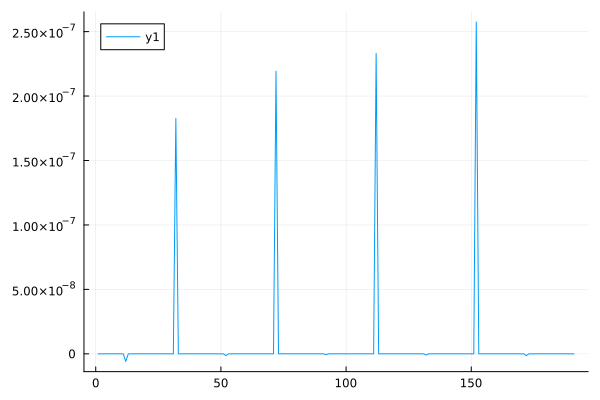

In [618]:
plot(all_utraj[1,410:600]*1e3/86400^2)

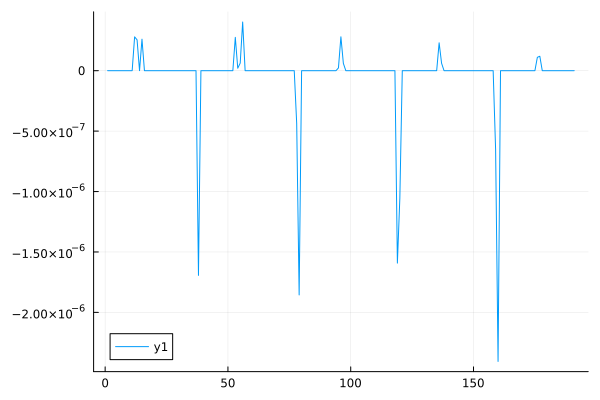

In [619]:
plot(all_utraj[2,410:600]*1e3/86400^2)

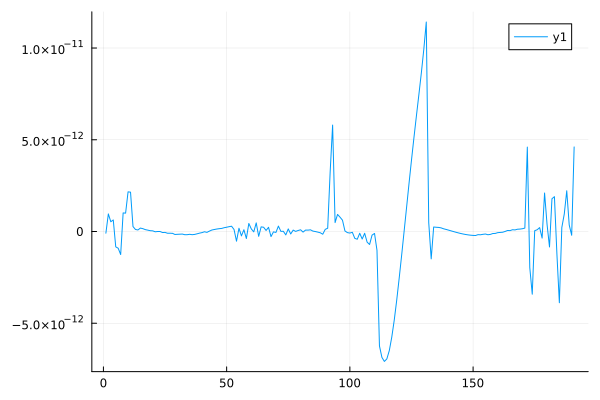

In [620]:
plot(all_utraj[3,410:600])

In [621]:
horizon 

41-element LinRange{Float64, Int64}:
 0.0, 0.00268661, 0.00537322, 0.00805982, …, 0.102091, 0.104778, 0.107464

In [622]:
Δt

0.002686608149766249

In [623]:
days_range = range(0,409, 410)

days = collect(days_range)*Δt

410-element Vector{Float64}:
 0.0
 0.002686608149766249
 0.005373216299532498
 0.008059824449298748
 0.010746432599064996
 0.013433040748831244
 0.016119648898597495
 0.018806257048363743
 0.02149286519812999
 0.02417947334789624
 ⋮
 1.0773298680562657
 1.080016476206032
 1.0827030843557983
 1.0853896925055646
 1.088076300655331
 1.090762908805097
 1.0934495169548633
 1.0961361251046295
 1.0988227332543958

In [624]:
days[41]

0.10746432599064995

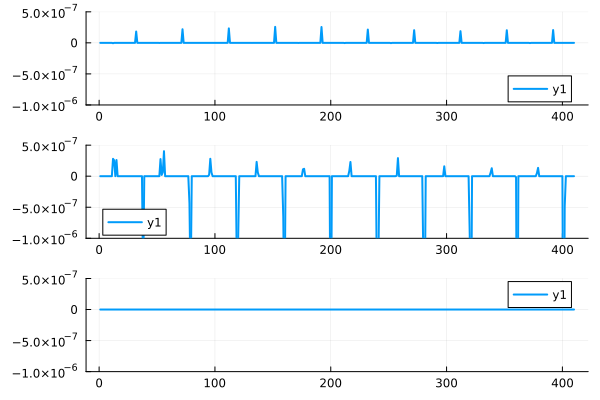

In [625]:
plot_range = (-10e-7, 5e-7)

plot1 = plot(all_utraj[1,410:819]*1e3/86400^2, linewidth = 2,ylim = plot_range,xlabel="")
plot2 = plot(all_utraj[2,410:819]*1e3/86400^2, linewidth = 2, ylim = plot_range)
plot3 = plot(all_utraj[3,410:819]*1e3/86400^2, linewidth=2, ylim = plot_range)


plot_layout = @layout [a;
                       b; 
                       c]

plot(plot1, plot2, plot3, layout=plot_layout)

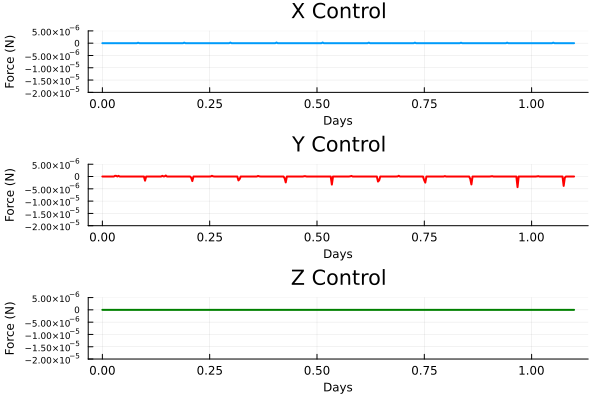

In [626]:
#this plots orbits 10-20

plot_range = (-2e-5, 5e-6)


plot1 = plot(days, all_utraj[1,410:819]*1e3/86400^2, linewidth = 2,ylim = plot_range, title= "X Control")
plot2 = plot(days, all_utraj[2,410:819]*1e3/86400^2, linewidth = 2, ylim = plot_range, title= "Y Control", linecolor="red")
plot3 = plot(days , all_utraj[3,410:819]*1e3/86400^2, linewidth=2, ylim = plot_range, title= "Z Control", linecolor="green")


plot_layout = @layout [a;
                       b; 
                       c]

control1020 = plot(plot1, plot2, plot3, layout=plot_layout, legend=false, xlabel="Days", xlabelfontsize=8, ylabel="Force (N)", ylabelfontsize=8, ytickfontsize = 6)

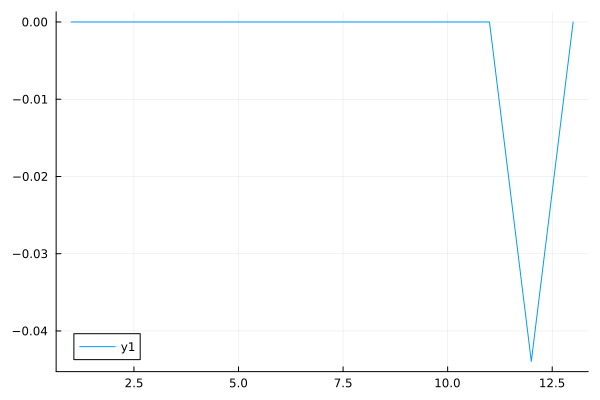

In [627]:
plot(all_utraj[1,410:422])

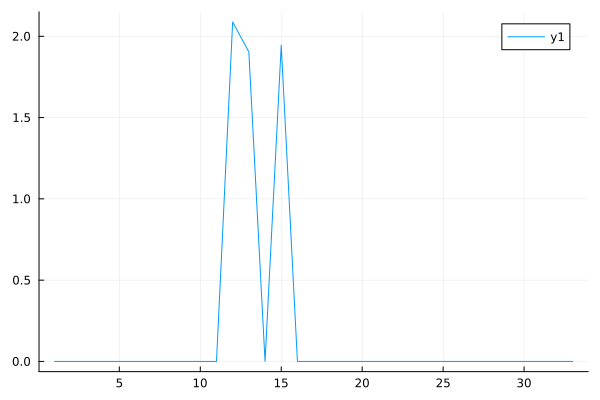

In [628]:
plot(all_utraj[2,410:442])

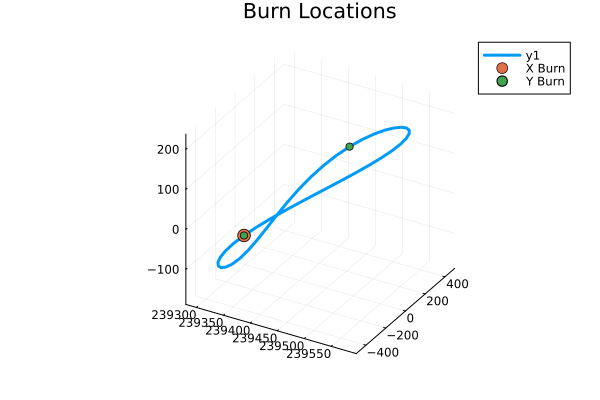

In [629]:
burn_locations = plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], linewidth = 3, title= "Burn Locations")
scatter!([reference_trajectory[1,12]],[reference_trajectory[2,12]],[reference_trajectory[3,12]], label="X Burn", markersize = 7)
scatter!([reference_trajectory[1,12], reference_trajectory[1,31]],[reference_trajectory[2,12], reference_trajectory[2,31]],[reference_trajectory[3,12], reference_trajectory[3,31]], label="Y Burn", markersize = 4)

In [630]:
#savefig( burn_locations, "burn_locations")

In [631]:
#savefig( control1020, "control1020")

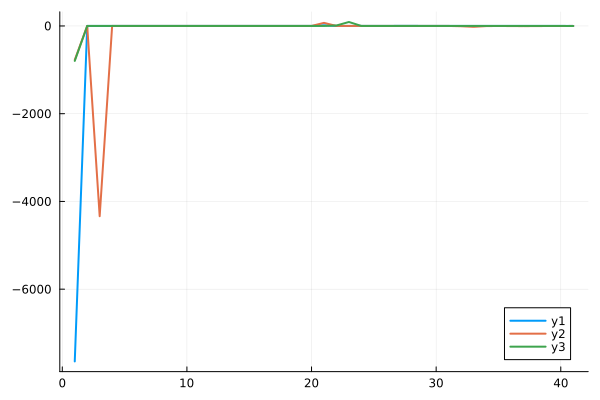

In [632]:
plot(all_utraj[1,1:41], linewidth = 2)
plot!(all_utraj[2,1:41], linewidth = 2)
plot!(all_utraj[3,1:41], linewidth=2)

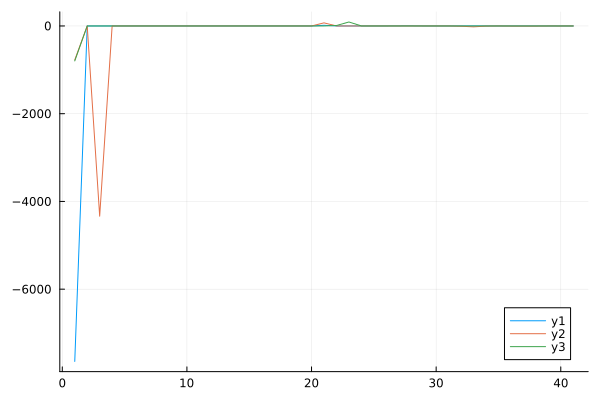

In [633]:
plot(all_utraj[1,1:41])
plot!(all_utraj[2,1:41])
plot!(all_utraj[3,1:41])

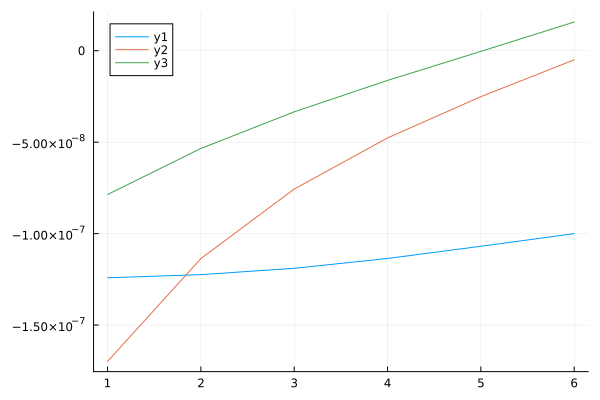

In [634]:
plot(all_utraj[1,10:15])
plot!(all_utraj[2,10:15])
plot!(all_utraj[3,10:15])

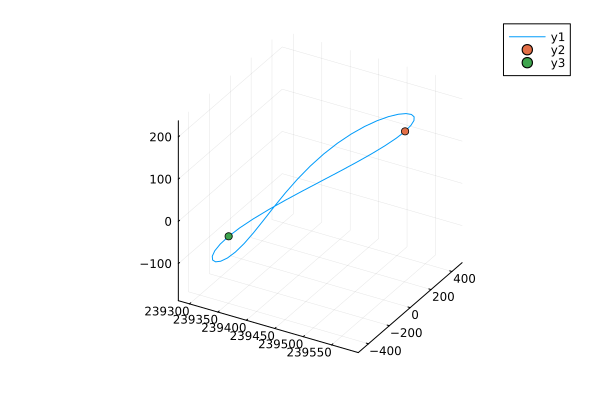

In [635]:
plot(all_xtraj[1,1:41], all_xtraj[2,1:41], all_xtraj[3,1:41])


scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]])
scatter!([all_xtraj[1,13]], [all_xtraj[2,13]], [all_xtraj[3,13]])

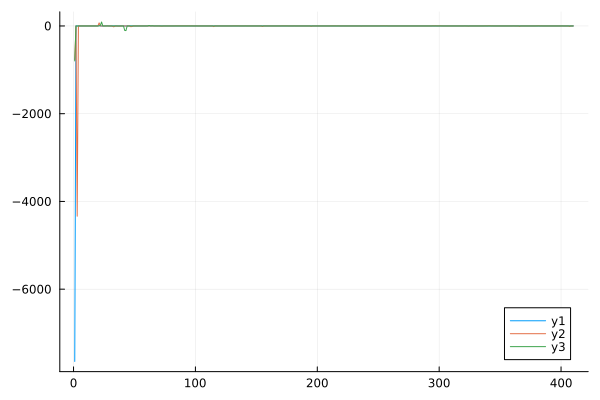

In [636]:
#this is for 5 orbits
plot(all_utraj[1,1:410])
plot!(all_utraj[2,1:410])
plot!(all_utraj[3,1:410])

In [637]:
# size(all_utraj)

In [639]:
one_orbit = all_utraj[:,41:80]

3×40 Matrix{Float64}:
  5.80954e-11     3.29e-11        2.47442e-11  …   1.28512e-12  -1.57411e-13
 -3.01374e-11    -6.12732e-11    -1.04822e-10     -1.95355e-12  -1.22833e-13
 -1.1903       -102.77         -106.593           -1.95324e-12  -2.4156e-12

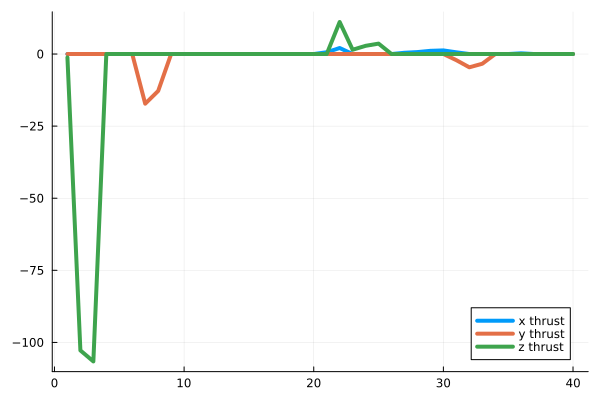

In [640]:
#the beginning thrust is to get it back on track since the initialization is off by 1e-3

plot(one_orbit[1,:], label="x thrust", linewidth=4)

plot!(one_orbit[2,:], label="y thrust", linewidth=4)

plot!(one_orbit[3,:], label="z thrust", linewidth=4)

In [641]:
#once we are at the orbit this is what it looks like
last_orbit = all_utraj[:,3961:end]

3×40 Matrix{Float64}:
  0.446984      2.54163e-8    7.73434e-10  …   7.08532e-12  3.79841e-12
 -4.52892e-10  -6.36036e-10  -1.05646e-9       3.85501e-12  4.54074e-12
 -1.9979       -0.594509     -0.412686        -5.68842e-13  5.51599e-13

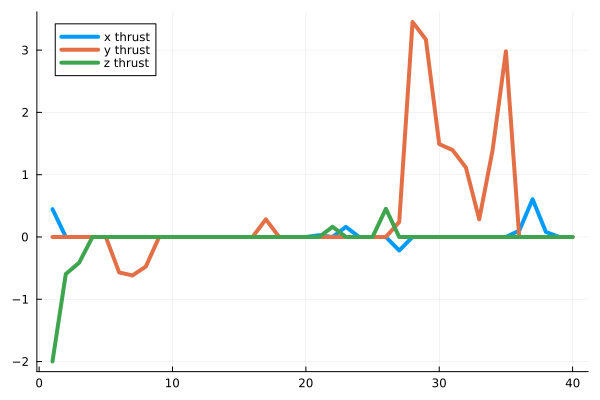

In [642]:
plot(last_orbit[1,:], label="x thrust", linewidth=4)

plot!(last_orbit[2,:], label="y thrust", linewidth=4)

plot!(last_orbit[3,:], label="z thrust", linewidth=4)

In [643]:
all_xtraj

6×4100 Matrix{Float64}:
      2.39588e5         2.39585e5  …       2.39585e5       2.39588e5
      2.88578e-15     -70.694             70.7106          6.75348e-5
    226.168           224.138            224.146         226.174
     -5.9486e-9     -1845.18            1829.04            0.000544985
 -26412.9          -26113.9           -26119.7        -26419.7
     -6.13861e-9    -1509.54       …    1508.08            0.0033925

In [644]:
all_utraj 

3×4000 Matrix{Float64}:
 -7646.59   -4.79586e-6     -6.13483e-7  …   7.08532e-12  3.79841e-12
  -775.045  -8.70465e-5  -4336.7             3.85501e-12  4.54074e-12
  -797.147  -1.13264e-5     -2.46669e-6     -5.68842e-13  5.51599e-13

In [645]:
norm(all_utraj[:,1])

7727.000881821465

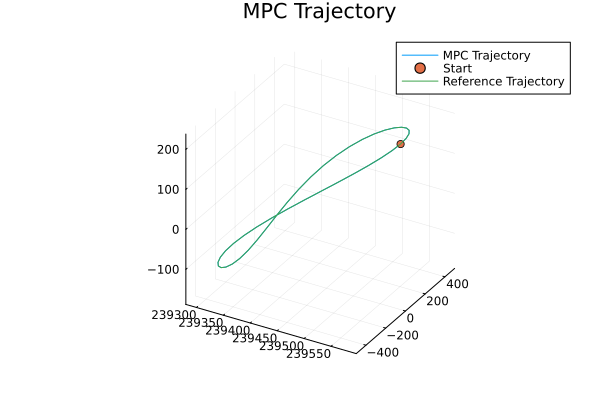

In [646]:
#plot the 100 orbits

plot(all_xtraj[1,:], all_xtraj[2,:], all_xtraj[3,:], label="MPC Trajectory", title="MPC Trajectory")

scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]], label="Start")

plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label = "Reference Trajectory")

In [647]:
all_xtraj 

6×4100 Matrix{Float64}:
      2.39588e5         2.39585e5  …       2.39585e5       2.39588e5
      2.88578e-15     -70.694             70.7106          6.75348e-5
    226.168           224.138            224.146         226.174
     -5.9486e-9     -1845.18            1829.04            0.000544985
 -26412.9          -26113.9           -26119.7        -26419.7
     -6.13861e-9    -1509.54       …    1508.08            0.0033925

In [648]:
all_xtraj

6×4100 Matrix{Float64}:
      2.39588e5         2.39585e5  …       2.39585e5       2.39588e5
      2.88578e-15     -70.694             70.7106          6.75348e-5
    226.168           224.138            224.146         226.174
     -5.9486e-9     -1845.18            1829.04            0.000544985
 -26412.9          -26113.9           -26119.7        -26419.7
     -6.13861e-9    -1509.54       …    1508.08            0.0033925

In [649]:
all_xtraj[1:3,41]/L 

3-element Vector{Float64}:
  1.0044381586565372
 -8.478920132156614e-9
  0.0009481211048302527

In [650]:
all_xtraj[4:6,41]/V_ 

3-element Vector{Float64}:
 -1.1337724857033751e-8
 -0.003858818921697933
  5.0449424755868796e-8

In [651]:
all_xtraj

6×4100 Matrix{Float64}:
      2.39588e5         2.39585e5  …       2.39585e5       2.39588e5
      2.88578e-15     -70.694             70.7106          6.75348e-5
    226.168           224.138            224.146         226.174
     -5.9486e-9     -1845.18            1829.04            0.000544985
 -26412.9          -26113.9           -26119.7        -26419.7
     -6.13861e-9    -1509.54       …    1508.08            0.0033925

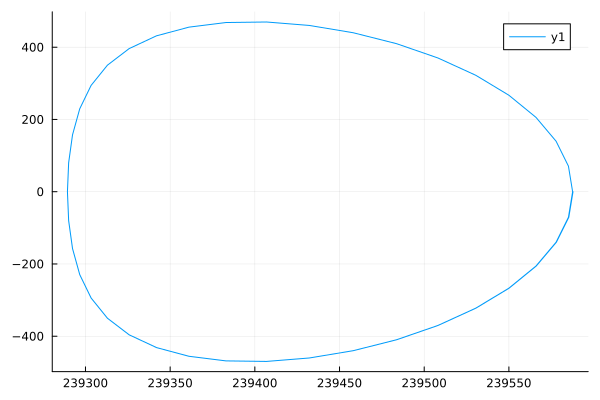

In [652]:
plot(all_xtraj[1, :],all_xtraj[2, :])

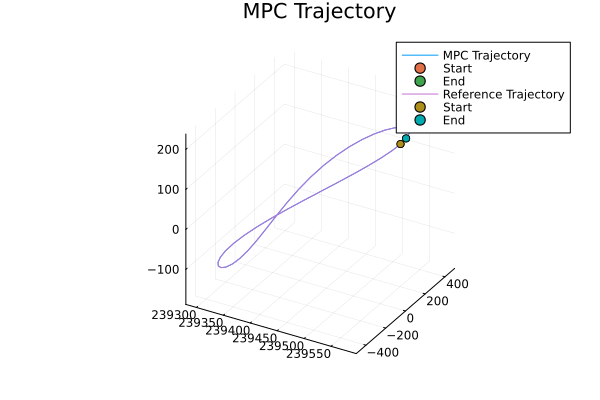

In [653]:
iter = 40

plot(all_xtraj[1,1:iter], all_xtraj[2,1:iter], all_xtraj[3,1:iter], label="MPC Trajectory", title="MPC Trajectory")
scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]], label="Start")
scatter!([all_xtraj[1,iter]], [all_xtraj[2,iter]], [all_xtraj[3,iter]], label="End")
plot!(reference_trajectory[1,1:iter], reference_trajectory[2,1:iter], reference_trajectory[3,1:iter], label = "Reference Trajectory")
scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]], label="Start")
scatter!([reference_trajectory[1,iter]], [reference_trajectory[2,iter]], [reference_trajectory[3,iter]], label="End")


In [654]:
#plot the final orbit
size(all_xtraj)

(6, 4100)

In [655]:
#i = 50
#plot(all_xtraj[1,40*(i-1)+1:40*i], all_xtraj[2,40*(i-1)+1:40*i], all_xtraj[3,40*(i-1)+1:40*i], label="MPC Trajectory", title="MPC Trajectory",lw=3)


#plot!(all_xtraj[1,41:80], all_xtraj[2,41:80], all_xtraj[3,41:80], label="MPC Trajectory", title="MPC Trajectory",lw=3)
#plot!(all_xtraj[1,81:120], all_xtraj[2,81:120], all_xtraj[3,81:120], label="MPC Trajectory", title="MPC Trajectory",lw=3)



#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3)


#plot(all_xtraj[1,41:80], all_xtraj[2,41:80], all_xtraj[3,41:80], label="MPC Trajectory", title="MPC Trajectory", lw=3)
#plot(all_xtraj[1,81:end], all_xtraj[2,81:end], all_xtraj[3,81:end], label="MPC Trajectory", title="MPC Trajectory", lw=3)

#scatter!([all_xtraj[1,1]],[all_xtraj[2,1]], [all_xtraj[3,1]], label="1")

#scatter!([all_xtraj[1,40]],[all_xtraj[2,40]], [all_xtraj[3,40]], label="40")

#scatter!([all_xtraj[1,41]],[all_xtraj[2,41]], [all_xtraj[3,41]], label="41")

#scatter!([all_xtraj[1,81]],[all_xtraj[2,81]], [all_xtraj[3,81]], label="80")

In [656]:
#plot(optimal_u[1,:].*acceleration_scale)

In [657]:
#plot(optimal_u[2,:])

In [658]:
#plot(optimal_u[3,:])

In [659]:
#acceleration_scale

In [660]:
#scaled_control.*acceleration_scale

In [661]:
#all_utraj

In [662]:
all_xtraj[:,21]

6-element Vector{Float64}:
 239289.3558514825
      0.007213948346693389
   -175.71582850899097
     -0.6650113447410095
  29978.067900506805
     -0.5221081176569023

In [663]:
all_xtraj[:,22]

6-element Vector{Float64}:
 239290.0681860555
     80.08063553010547
   -172.38191782743198
    540.5272223405807
  29459.463676470652
   2469.1355211988866

In [664]:
all_utraj

3×4000 Matrix{Float64}:
 -7646.59   -4.79586e-6     -6.13483e-7  …   7.08532e-12  3.79841e-12
  -775.045  -8.70465e-5  -4336.7             3.85501e-12  4.54074e-12
  -797.147  -1.13264e-5     -2.46669e-6     -5.68842e-13  5.51599e-13

In [665]:
#this is already in units of km/(days)^2
scaled_control = all_utraj

3×4000 Matrix{Float64}:
 -7646.59   -4.79586e-6     -6.13483e-7  …   7.08532e-12  3.79841e-12
  -775.045  -8.70465e-5  -4336.7             3.85501e-12  4.54074e-12
  -797.147  -1.13264e-5     -2.46669e-6     -5.68842e-13  5.51599e-13

In [666]:
all_Δxtraj[:,1]

6-element Vector{Float64}:
 0.23852899999474175
 0.0
 0.0
 0.0
 6.8465908561811375
 0.0

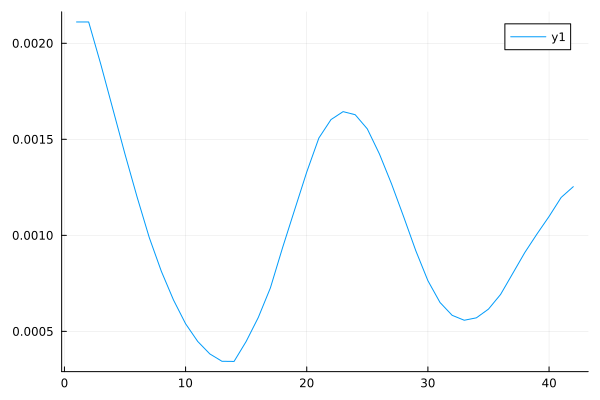

In [667]:
plot(all_Δxtraj[1,41:82])

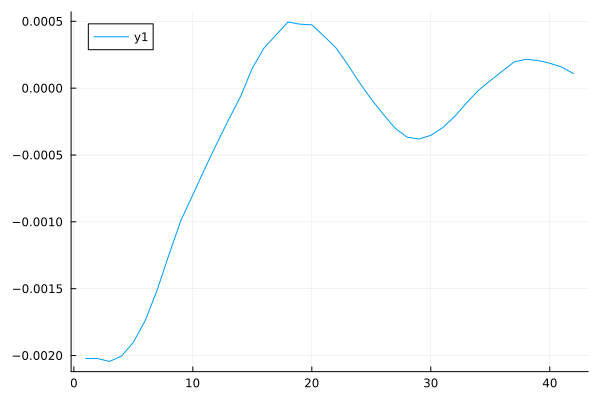

In [668]:
plot(all_Δxtraj[2,41:82])

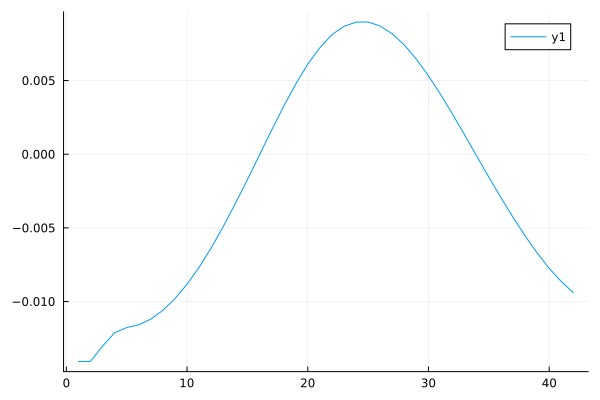

In [669]:
plot(all_Δxtraj[3,41:82])

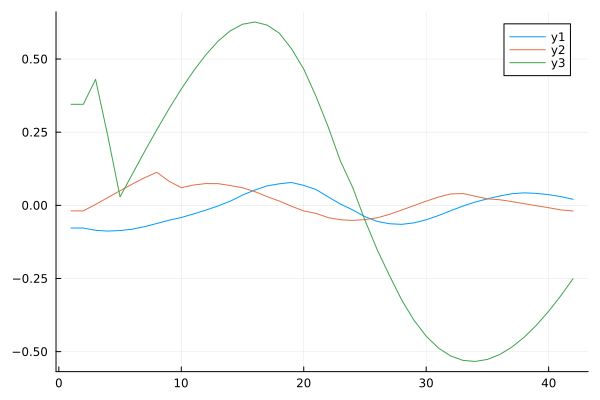

In [670]:
plot(all_Δxtraj[4,41:82])
plot!(all_Δxtraj[5,41:82])
plot!(all_Δxtraj[6,41:82])

In [671]:
#the Δt is in SI units (days)

In [673]:
#integrate over the timestep to get the velocity cost in km/day
x_cost = sum(abs.(scaled_control[1,:]))*(Δt)
y_cost = sum(abs.(scaled_control[2,:]))*(Δt)
z_cost = sum(abs.(scaled_control[3,:]))*(Δt)

3.8959732659478745

In [674]:
x_cost

21.0882144804049

In [675]:
25e-3*86400^2*Δt/86400

5.803073603495098

In [676]:
#velocity cost in m/s
#dividing by 86400 to get into seconds bc currently it is in days

#units are good (checked in simulation_test)
x_cost_ms = x_cost*(1e3/86400)
y_cost_ms = y_cost*(1e3/86400)
z_cost_ms = z_cost*(1e3/86400)

display(x_cost_ms)
display(y_cost_ms)
display(z_cost_ms)

0.24407655648616783

0.22745593640995984

0.04509228317069299

In [677]:
all_cost = x_cost_ms + y_cost_ms + z_cost_ms 

0.5166247760668207

In [ ]:
cost_per_rev = all_cost/orbit_num

In [ ]:
# #Exclude the first 10 timesteps to fix the injection error
# x_cost_good = sum(abs.(scaled_control[1,42:end]))*(Δt) *(1e3/86400)
# y_cost_good = sum(abs.(scaled_control[2,42:end]))*(Δt) *(1e3/86400)
# z_cost_good = sum(abs.(scaled_control[3,42:end]))*(Δt) *(1e3/86400)

# display(x_cost_good)
# display(y_cost_good)
# display(z_cost_good)

In [ ]:
# #cost for 95 revs
# all_cost_good = x_cost_good + y_cost_good + z_cost_good

In [ ]:
#final_mpc = reference_trajectory + optimal_x

In [ ]:
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")

In [ ]:
#initially
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")
#scatter!([final_mpc[1,1]], [final_mpc[2,1]],[final_mpc[3,1]], label= "Start Point")

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Trajectory")

In [ ]:
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")
#scatter!([final_mpc[1,1]], [final_mpc[2,1]], [final_mpc[3,1]], label= "Start Point")
#scatter!([final_mpc[1,end]], [final_mpc[2,end]], [final_mpc[3,end]], label= "End Point")

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Trajectory")

In [ ]:
#diff = final_mpc - reference_trajectory

In [ ]:
#plot(diff[1,:])
#plot!(diff[2,:])
#plot!(diff[3,:])

In [ ]:
plot(all_xtraj[1,:], all_xtraj[2,:])

In [ ]:
all_xtraj[:,end]

In [ ]:
all_optimal_x[:,:,end]

In [ ]:
dot(all_optimal_x[:,end,end], unstable_directions_2[:,21])    

In [ ]:
all_optimal_x

In [ ]:
end_state = all_xtraj[:,end]

end_state_sim = just_dynamics_integrate(end_state, 2.75*sol_t_final[end])


end_state_traj = get_state(end_state_sim)

In [ ]:
#testing
#end_state_sim = reference_trajectory[:,end]

In [ ]:
delta_end = end_state - reference_trajectory[:,end]

In [ ]:
#end_state_test = reference_trajectory[:,end] - delta_end

In [ ]:
#correct_end_state = end_state_test - reference_trajectory[:,end]

In [ ]:
#end_state_sim_correct = just_dynamics_integrate(end_state_test, 2.0*sol_t_final[end])


#end_state_traj_correct = get_state(end_state_sim_correct)

In [ ]:
deltaaa = xtraj_test[:,1:21] - all_xtraj[:,1:21]

In [ ]:
plot(deltaaa[6,:])

In [ ]:
half_test = all_xtraj[:,1:21] - reference_trajectory[:,1:21]

In [ ]:
constraint_check_test = zeros(21)
for i=1:21
    constraint_check_test[i] = dot(half_test[:,i], unstable_directions[:,i])

end


In [ ]:
constraint_check_test

In [ ]:
#check the constraint...
constraint_check = zeros(4100)
for k=1:100
    for i=1:41

        constraint_check[41*(k-1)+i] = dot(unstable_directions[:,i], all_Δxtraj[:, 41*(k-1)+i]) #> 0 

    end
end

In [ ]:
constraint_check[1600:1625]

In [ ]:
plot(constraint_check.>0)

In [ ]:
constraint_check[1:15]

In [ ]:
0.77 * 1e3/86400

In [ ]:
constraint_check[50:75]

In [ ]:
#going to check what happens if I simulate the 4000 controls on the scaled model
all_utraj

In [ ]:
xtraj_test = integrate_oneperiod(all_xtraj[:,1], all_utraj[:,1:40])

In [ ]:
Δt/time_scale

In [ ]:
norm(xtraj_test[1:3,end]- xtraj_test[1:3,1])/L

In [ ]:
plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

In [ ]:
unstable_directions[:,end]


#for the negative manifold, the final state is satisfying the constraint and that's why it goes to the 
#left 

#however, for the positive manifold, it is satisfying the negative manifold constraint...

In [ ]:
dot(delta_end, unstable_directions[:,end])

In [ ]:
# #check this constraint 
# #works with pi/5 too 

# c_test = unstable_directions[:,end]/tan(pi/6)
# #c_test = unstable_directions[:,end]/tan((pi/2) - deg2rad(60))

# manifold_constraint_test = norm(delta_end) - c_test'*(delta_end)

# manifold_constraint_test
# #push!(cons, manifold_constraint <= 0)

In [ ]:
#angle away from the unstable manifold
dot(unstable_directions[:,end], delta_end)*norm(delta_end)*180/pi

In [ ]:
#escapes on the right for positive unstable direction!
plot(end_state_traj[1,:], end_state_traj[2,:])

scatter!([end_state_traj[1,1]], [end_state_traj[2,1]])

In [ ]:
#plot(end_state_traj_correct[1,:], end_state_traj_correct[2,:])

#goes to the right when it is in the positive manifold direction. hypothesis is true. however, 
#the solver is giving solutions that does not satisfy this constraint. need to figure out why...

In [ ]:
#needs to be a super small perturbation in order to stay stable

forward_rollout = zeros(6, N_period)

#forward_rollout[:,1] = [1e-3, 0, 0, 0, 1e-6,0]


forward_rollout[:,1] = [1e-9, 0, 0, 0, 1e-9, 0]

for i=1:N_period-1
   
    #diverges with no control 
    #forward_rollout[:,i+1] = all_Ad[:,:,i]*forward_rollout[:,i]
    
    #with disturbances it just blows up
    forward_rollout[:,i+1] = all_Ad[:,:,i]*forward_rollout[:,i] #+ randn(6)*1e-4
    
end
    

In [ ]:
reference_trajectory

In [ ]:
nocontrol = forward_rollout + reference_trajectory

In [ ]:
plot(nocontrol[1,:], nocontrol[2,:], nocontrol[3,:], lw=3, label="No Control")
plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3, label="Reference Trajectory")
scatter!([nocontrol[1,1]], [nocontrol[2,1]], [nocontrol[3,1]], label="No Control Start")
scatter!([nocontrol[1,end]], [nocontrol[2,end]],[nocontrol[3,end]], label="No Control End")

In [ ]:
# plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], lw=3, label="MPC Control")
# plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3, label="Reference Trajectory")
# scatter!([final_mpc[1,1]], [final_mpc[2,1]], [final_mpc[3,1]], label="No Control Start")
# scatter!([final_mpc[1,end]], [final_mpc[2,end]], [final_mpc[3,end]],  label="No Control End", aspectratio = true)

In [ ]:
position_tube_norm = zeros(N_period*orbit_num)

velocity_tube_norm = zeros(N_period*orbit_num)

In [ ]:
orbit_num

In [ ]:
svd(V[:,:,1]).S

In [ ]:
for i=1:N_period*orbit_num
   
    position_tube_norm[i]= norm(all_Δxtraj[1:3,i])
    
    velocity_tube_norm[i]= norm(all_Δxtraj[4:6,i])
    
end

In [ ]:
ctg_constraint = zeros(6, N_period)
dist_from_center = zeros(6, N_period)

In [ ]:
(ones(6).*0.1)./eigen(V[:,:,1]).values

In [ ]:
test_v = (ones(6).*0.1)./eigen(V[:,:,1]).vectors

In [ ]:
test_v * [1,1,1,0,0,0]

In [ ]:
V

In [ ]:
for i= 1:N_period

    e_decomp = eigen(V[:,:,i])

    #inverse same as transpose in this case
    y = inv(e_decomp.vectors) * all_Δxtraj[:,i]

    dist_from_center[:,i] = y

    ctg_constraint[:,i] = sqrt.(1e-3 .*ones(6)./e_decomp.values)


end

    

In [ ]:
ctg_constraint


In [ ]:
dist_from_center

In [ ]:
all_Δxtraj[:,1]'*V[:,:,1]*all_Δxtraj[:,1]

In [ ]:
dist_from_center[1,:]*L

In [ ]:
plot(dist_from_center[1,:], label="x")
plot!(ctg_constraint[1,:], label="x axis constraint")

In [ ]:
plot(dist_from_center[2,:], label="y")
plot!(ctg_constraint[2,:], label="y axis constraint")

In [ ]:
plot(dist_from_center[3,:], label="z")
plot!(ctg_constraint[3,:], label="z axis constraint")

In [ ]:
plot(dist_from_center[4,:], label="vx")
plot!(ctg_constraint[4,:], label="vx axis constraint")

In [ ]:
plot(dist_from_center[5,:], label="vy")
plot!(ctg_constraint[5,:], label="vy axis constraint")

In [ ]:
plot(dist_from_center[6,:], label="vz")
plot!(ctg_constraint[6,:], label="vz axis constraint")

In [ ]:
all_Δxtraj[:,1]

In [ ]:
V[:,:,1]

In [ ]:
#test.vectors*diagm(test.values)*test.vectors'

In [ ]:
#inv(test.vectors)

In [ ]:
#test.vectors'

In [ ]:
# #finding the magnitude of the principle axes of the ellipsoid
# magnitude_principle_axes = zeros(6, N_period)


# for i=1:N_period
    
#     magnitude_principle_axes[:,i] = svd(V[:,:,i]).S
    
    
# end

In [ ]:
# plot(magnitude_principle_axes[1,:])
# plot!(magnitude_principle_axes[2,:])
# plot!(magnitude_principle_axes[3,:])

In [ ]:
# plot(magnitude_principle_axes[4,:])
# plot!(magnitude_principle_axes[5,:])
# plot!(magnitude_principle_axes[6,:])

In [ ]:
plot(all_Δxtraj[1,:])

plot!(all_Δxtraj[2,:])

plot!(all_Δxtraj[3,:])

In [ ]:
plot(all_Δxtraj[4,:])

plot!(all_Δxtraj[5,:])

plot!(all_Δxtraj[6,:])